<div align="center"><h1><b>Step 4: Create and Compare Various Machine Learning Models to Classify Influence Operations Versus Legitimate Twitter Users</b></h1></div>

**Outline**

1. Conduct exploratory data analysis to visualize distribution of data, time distribution of data, word frequency, scatter plot matrix, and bar graphs of user features
2. Compare the performance of models trained on only the BoW vectors to predict IO versus legitimate users. Models evaluated include Multinomial Naive Bayes and Stochastic Gradient Descent with both Count Vectorization and TFIDF approaches, using Grid Search to determine optimal parameters.
3. Compare performance of a Muli-Layer Perceptron Neural Network train on BoW vectors using Count Vectorization
4. Compare Random Forests and Support Vector Classification on the non-BoW user pattern of life metrics
5. Combine models from the BoW and pattern-of-life approaches to evaluate any improvement using ensemble voting methods

In [3]:
# Import necessary libraries

# For accessing Google Drive Files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

# Connect and authenticate Google Drive with Google CoLab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive.mount('/drive')
drive = GoogleDrive(gauth)

import CS3315Project.tweetProcessing as tweetProcessing
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
import itertools
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
import pickle

Mounted at /drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# Grab tweets and users

userfile = drive.CreateFile({'id': 'insert file id'}) 
userfile.GetContentFile('all_users_processed.csv')

tweetfile = drive.CreateFile({'id': 'insert file id'}) 
tweetfile.GetContentFile('all_tweets_processed.csv')

all_users = pd.read_csv('all_users_processed.csv')
all_tweets = pd.read_csv('all_tweets_processed.csv')

# There are some following and follower counts that are null, we will fill these with 0
all_users = all_users.fillna(0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Create subsets of data for visualizations

all_tweets['tweet_time'] = pd.to_datetime(all_tweets['tweet_time'])

leg_tweets = all_tweets[all_tweets['info_op'] == 0]
dis_tweets = all_tweets[all_tweets['info_op'] == 1]

leg_users = all_users[all_users['info_op'] == 0]
dis_users = all_users[all_users['info_op'] == 1]

In [7]:
# Look at the tweet data

print(all_tweets.info())
all_tweets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22873094 entries, 0 to 22873093
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   tweetid        int64         
 1   userid         object        
 2   tweet_time     datetime64[ns]
 3   is_retweet     int64         
 4   quote_count    float64       
 5   like_count     float64       
 6   retweet_count  float64       
 7   hashtags       int64         
 8   urls           int64         
 9   user_mentions  int64         
 10  BoW            object        
 11  info_op        int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 2.0+ GB
None


,tweetid,userid,tweet_time,is_retweet,quote_count,like_count,retweet_count,hashtags,urls,user_mentions,BoW,info_op
0,1334343130880073729,81914168,2020-12-03 03:46:07,0,0.0,0.0,0.0,0,0,1,"['rose', 'scent', 'soap']",0
1,1334342111454515202,81914168,2020-12-03 03:42:04,1,0.0,1.0,0.0,0,0,4,"['antifascistf', 'lukeobrien', 'luke', 'sock',...",0
2,1334327421684867074,81914168,2020-12-03 02:43:42,1,1.0,0.0,1.0,0,0,1,"['staunton', 'woman', 'face', 'year', 'probati...",0
3,1334327074627203072,81914168,2020-12-03 02:42:19,1,7.0,0.0,7.0,0,0,1,"['cops', 'prevent', 'crime']",0
4,1334326968305717250,81914168,2020-12-03 02:41:54,0,0.0,0.0,0.0,0,0,1,[],0


In [8]:
# Look at the user data that we will use in the models 

print(all_users.info())
all_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   userid                    8594 non-null   object 
 1   user_reported_location    8594 non-null   int64  
 2   user_profile_description  8594 non-null   int64  
 3   follower_count            8594 non-null   float64
 4   following_count           8594 non-null   float64
 5   BoW                       8594 non-null   object 
 6   retweet_ratio             8594 non-null   float64
 7   english_tweet_proportion  8594 non-null   float64
 8   earliest_tweet_time       8594 non-null   int64  
 9   latest_tweet_time         8594 non-null   int64  
 10  average_tweet_time        8594 non-null   int64  
 11  median_tweet_time         8594 non-null   int64  
 12  tweet_count               8594 non-null   int64  
 13  stddev_tweet_time         8594 non-null   int64  
 14  mode_0  

,userid,user_reported_location,user_profile_description,follower_count,following_count,BoW,retweet_ratio,english_tweet_proportion,earliest_tweet_time,latest_tweet_time,average_tweet_time,median_tweet_time,tweet_count,stddev_tweet_time,mode_0,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_7,mode_8,mode_9,mode_10,mode_11,mode_12,mode_13,mode_14,mode_15,mode_16,mode_17,mode_18,mode_19,mode_20,mode_21,mode_22,mode_23,avg_tweets_per_week,avg_tweets_per_day,avg_tweets_per_hour,avg_tweets_per_min,avg_quote_count,avg_like_count,avg_retweet_count,avg_hashtags,avg_urls,avg_user_mentions,info_op
0,81914168,1,1,2654.0,2026.0,"['rose', 'scent', 'soap', 'antifascistf', 'luk...",0.603425,0.882136,0,2357,2049,1648,2978,727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,595.600000,99.266667,4.284892,0.071487,571.801880,1.357623,571.801880,0.063130,0.140363,1.161518,0
1,1209338232946614272,1,1,0.0,84.0,"['look', 'like', 'wrong', 'curtain', 'leave', ...",0.363636,0.890909,6,2358,156,415,165,818,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.024390,0.583039,0.024369,0.000406,6088.878788,0.430303,6088.878788,0.054545,0.169697,1.030303,0
2,1003903106730680320,0,1,0.0,15.0,"['championforaca', 'mcdoozie', 'sirelkmn', 'vi...",0.027778,0.986111,4,2346,244,738,72,722,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.562500,0.080717,0.003367,0.000056,315.652778,0.347222,315.652778,0.180556,0.055556,2.041667,0
3,1269876357472772097,1,1,85.0,465.0,"['better', 'lmao', 'friend', 'like', 'joke', '...",0.027624,0.937845,0,2359,2,1523,724,822,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.200000,5.443609,0.228608,0.003812,3779.531768,1.493094,3779.531768,0.078729,0.029006,0.569061,0
4,183036128,1,1,159854.0,2312.0,"['international', 'flight', 'arrive', 'melbour...",0.152000,0.999333,0,2359,427,78,3000,653,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,428.571429,73.170732,3.112033,0.051902,7.644667,13.691667,7.644667,1.171333,0.365000,0.746667,0


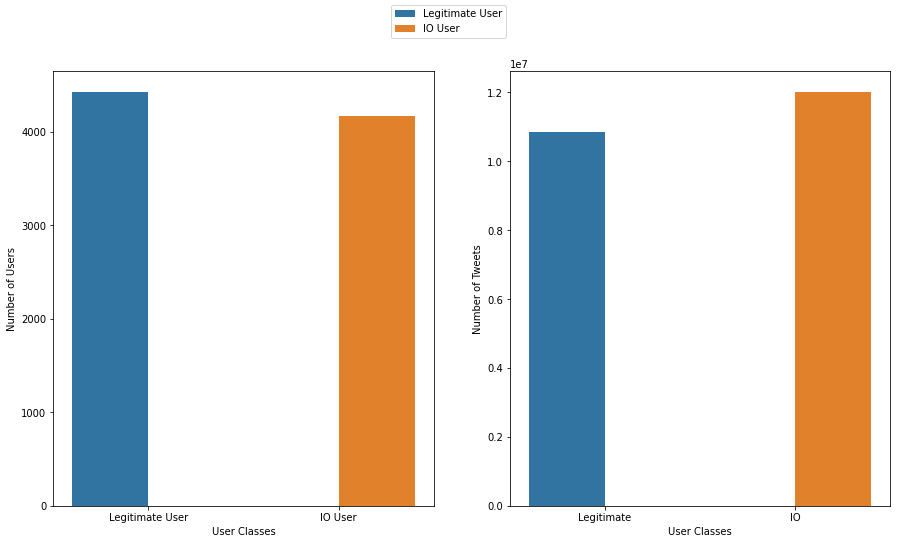

In [9]:
# Show total number of tweets per user in each class, total number of users per class

figure, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,8))

leguser_counts = leg_users['info_op'].value_counts().to_frame()
leguser_counts = leguser_counts.rename(columns={'info_op':'user_num'})
leguser_counts['user_type'] = 'Legitimate User'

disuser_counts = dis_users['info_op'].value_counts().to_frame()
disuser_counts = disuser_counts.rename(columns={'info_op':'user_num'})
disuser_counts['user_type'] = 'IO User'

user_values = pd.concat([leguser_counts, disuser_counts], ignore_index=True)
#user_values = user_values.reset_index()

usrplt = sns.barplot(x='user_type', 
            y='user_num', 
            hue='user_type', 
            data=user_values, ax=axes[0])
usrplt.set_xlabel("User Classes",fontsize=10)
usrplt.set_ylabel("Number of Users", fontsize=10)
usrplt.legend_.remove()


legtweets_counts = leg_tweets['info_op'].value_counts().to_frame()
legtweets_counts = legtweets_counts.rename(columns={'info_op':'tweet_num'})
legtweets_counts['user_type'] = 'Legitimate'

distweets_counts = dis_tweets['info_op'].value_counts().to_frame()
distweets_counts = distweets_counts.rename(columns={'info_op':'tweet_num'})
distweets_counts['user_type'] = 'IO'

tweet_values = pd.concat([legtweets_counts, distweets_counts], ignore_index=True)
#tweet_values = tweet_values.reset_index()

twtplt = sns.barplot(x='user_type', 
            y='tweet_num', 
            hue='user_type', 
            data=tweet_values, ax=axes[1])
twtplt.set_xlabel("User Classes",fontsize=10)
twtplt.set_ylabel("Number of Tweets", fontsize=10)
twtplt.legend_.remove()

handles, labels = usrplt.get_legend_handles_labels()
legend = figure.legend(handles, labels, loc='upper center')

In [10]:
# Look at legitimate tweet metrics

all_tweets[all_tweets['info_op']==0].describe()

,tweetid,is_retweet,quote_count,like_count,retweet_count,hashtags,urls,user_mentions,info_op
count,1.084947e+07,1.084947e+07,1.084947e+07,1.084947e+07,1.084947e+07,1.084947e+07,1.084947e+07,1.084947e+07,10849470.0
mean,1.268309e+18,5.195665e-01,4.335231e+03,3.083820e+00,4.335231e+03,2.497145e-01,1.545172e-01,1.135983e+00,0.0
std,1.485423e+17,4.996170e-01,2.711552e+04,5.588440e+02,2.711552e+04,9.163178e-01,3.740042e-01,1.658661e+00,0.0
min,2.682036e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.282347e+18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0
50%,1.318271e+18,1.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0
75%,1.328441e+18,1.000000e+00,3.590000e+02,0.000000e+00,3.590000e+02,0.000000e+00,0.000000e+00,1.000000e+00,0.0
max,1.335062e+18,1.000000e+00,3.369932e+06,1.438691e+06,3.369932e+06,3.500000e+01,1.000000e+01,5.000000e+01,0.0


In [11]:
# Look at IO tweet metrics

all_tweets[all_tweets['info_op']==1].describe()

,tweetid,is_retweet,quote_count,like_count,retweet_count,hashtags,urls,user_mentions,info_op
count,1.202362e+07,1.202362e+07,1.201492e+07,1.201492e+07,1.201492e+07,1.202362e+07,1.202362e+07,1.202362e+07,12023624.0
mean,6.449772e+17,3.641086e-01,2.011342e-01,1.014753e+01,5.360552e+00,9.040530e-01,4.245070e-01,6.161715e-01,1.0
std,1.986638e+17,4.811793e-01,1.141200e+01,2.682988e+02,1.259921e+02,9.692403e-01,5.028863e-01,9.805700e-01,0.0
min,1.747086e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,5.221149e+17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
50%,6.345425e+17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.0
75%,7.938276e+17,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0
max,1.296879e+18,1.000000e+00,1.163300e+04,3.258260e+05,1.236170e+05,3.200000e+01,6.000000e+00,5.000000e+01,1.0


In [12]:
# Look at legitimate user metrics

all_users[all_users['info_op']==0].describe()

,user_reported_location,user_profile_description,follower_count,following_count,retweet_ratio,english_tweet_proportion,earliest_tweet_time,latest_tweet_time,average_tweet_time,median_tweet_time,tweet_count,stddev_tweet_time,mode_0,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_7,mode_8,mode_9,mode_10,mode_11,mode_12,mode_13,mode_14,mode_15,mode_16,mode_17,mode_18,mode_19,mode_20,mode_21,mode_22,mode_23,avg_tweets_per_week,avg_tweets_per_day,avg_tweets_per_hour,avg_tweets_per_min,avg_quote_count,avg_like_count,avg_retweet_count,avg_hashtags,avg_urls,avg_user_mentions,info_op
count,4427.000000,4427.00000,4.427000e+03,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.00000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.0
mean,0.667043,0.86763,2.973179e+03,1195.896544,0.498952,0.823195,20.891800,2332.389880,1111.854755,998.423763,2450.749944,554.532641,0.02801,0.045403,0.068895,0.087418,0.079738,0.083126,0.046533,0.028688,0.018749,0.017845,0.015586,0.021007,0.024396,0.032302,0.039982,0.066185,0.053535,0.058505,0.048792,0.039530,0.039756,0.031172,0.025073,0.025977,244.003549,43.829397,2.054477,0.034790,4386.457036,2.827880,4386.457036,0.260717,0.152879,1.130507,0.0
std,0.471324,0.33893,2.959120e+04,4606.297245,0.315631,0.191386,76.387688,100.521965,854.754885,515.510849,908.683785,250.680760,0.16502,0.208210,0.253305,0.282479,0.270918,0.276104,0.210659,0.166946,0.135651,0.132403,0.123882,0.143425,0.154292,0.176820,0.195939,0.248633,0.225123,0.234722,0.215456,0.194875,0.195408,0.173803,0.156366,0.159084,344.171114,79.398454,9.708288,0.176467,7854.218525,24.833987,7854.218525,0.581846,0.152525,0.861046,0.0
min,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,635.000000,1.000000,45.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090278,0.012987,0.000542,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.00000,1.070000e+02,200.000000,0.211189,0.787554,0.000000,2356.000000,213.000000,644.000000,2418.500000,447.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.387578,3.103961,0.130085,0.002168,394.276904,0.143079,394.276904,0.037018,0.058632,0.787542,0.0
50%,1.000000,1.00000,3.520000e+02,473.000000,0.491126,0.894070,0.000000,2359.000000,1057.000000,1123.000000,2941.000000,641.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.961538,15.711957,0.661521,0.011028,1763.955853,0.494078,1763.955853,0.104752,0.112356,1.061718,0.0
75%,1.000000,1.00000,1.080000e+03,1072.500000,0.790361,0.942154,3.000000,2359.000000,2036.000000,1436.000000,2985.000000,744.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,332.944444,53.576786,2.278962,0.038037,5104.040653,1.315490,5104.040653,0.282001,0.196017,1.304730,0.0
max,1.000000,1.00000,1.548792e+06,174488.000000,1.000000,1.000000,2050.000000,2359.000000,2359.000000,2142.000000,3000.000000,1045.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000

In [13]:
# Look at IO user metrics

all_users[all_users['info_op']==1].describe()

,user_reported_location,user_profile_description,follower_count,following_count,retweet_ratio,english_tweet_proportion,earliest_tweet_time,latest_tweet_time,average_tweet_time,median_tweet_time,tweet_count,stddev_tweet_time,mode_0,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_7,mode_8,mode_9,mode_10,mode_11,mode_12,mode_13,mode_14,mode_15,mode_16,mode_17,mode_18,mode_19,mode_20,mode_21,mode_22,mode_23,avg_tweets_per_week,avg_tweets_per_day,avg_tweets_per_hour,avg_tweets_per_min,avg_quote_count,avg_like_count,avg_retweet_count,avg_hashtags,avg_urls,avg_user_mentions,info_op
count,4167.000000,4167.000000,4.167000e+03,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4.167000e+03,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.0
mean,0.790257,0.706983,4.159915e+03,965.773698,0.320500,0.512102,243.109191,2160.571634,1136.097192,1075.957763,2885.438925,399.184785,0.014639,0.028798,0.030238,0.010559,0.003600,0.004560,0.009359,0.027838,0.042717,0.069114,0.058075,0.047276,0.083273,0.094072,0.167747,0.107031,0.069594,0.045596,0.024718,0.017759,0.029518,0.023758,0.028078,0.018239,45.025389,7.930087,0.578350,8.806216e-02,0.115772,3.609553,2.059180,0.935954,0.307672,0.474697,1.0
std,0.407174,0.455201,5.346724e+04,3664.244055,0.340149,0.464863,409.975965,394.427816,603.307011,537.651203,9103.451243,241.169207,0.120117,0.167258,0.171261,0.102226,0.059897,0.067379,0.096301,0.164528,0.202242,0.253679,0.233914,0.212255,0.276328,0.291965,0.373686,0.309190,0.254493,0.208633,0.155283,0.132089,0.169273,0.152313,0.165215,0.133829,224.014695,44.604745,3.664516,5.647711e-01,1.724195,45.196682,21.938598,0.480336,0.286166,0.457561,0.0
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005495,0.000787,0.000033,5.470109e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,0.000000,7.100000e+01,116.000000,0.011184,0.004373,1.000000,2127.500000,1019.500000,944.000000,177.500000,232.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.203189,0.765881,0.032163,5.361460e-04,0.000000,0.001404,0.002558,0.678403,0.077483,0.058824,1.0
50%,1.000000,1.000000,1.350000e+02,257.000000,0.172722,0.800000,13.000000,2346.000000,1259.000000,1244.000000,652.000000,420.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.321429,2.211039,0.114628,1.911991e-03,0.000000,0.010638,0.020979,0.921953,0.214055,0.380546,1.0
75%,1.000000,1.000000,5.615000e+02,638.000000,0.612927,0.972133,340.500000,2359.000000,1436.000000,1355.000000,2799.500000,546.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.393129,5.813542,0.293252,4.888112e-03,0.000000,0.039997,0.105564,1.083128,0.476994,0.800000,1.0
max,1.000000,1.000000,2.883076e+06,99855.000000,1.000000,1.000000,2344.000000,2359.000000,2359.000000,2346.000000,310781.000000,1112.000000,1.000000,1.000000,1.000000,1.000000,1.0

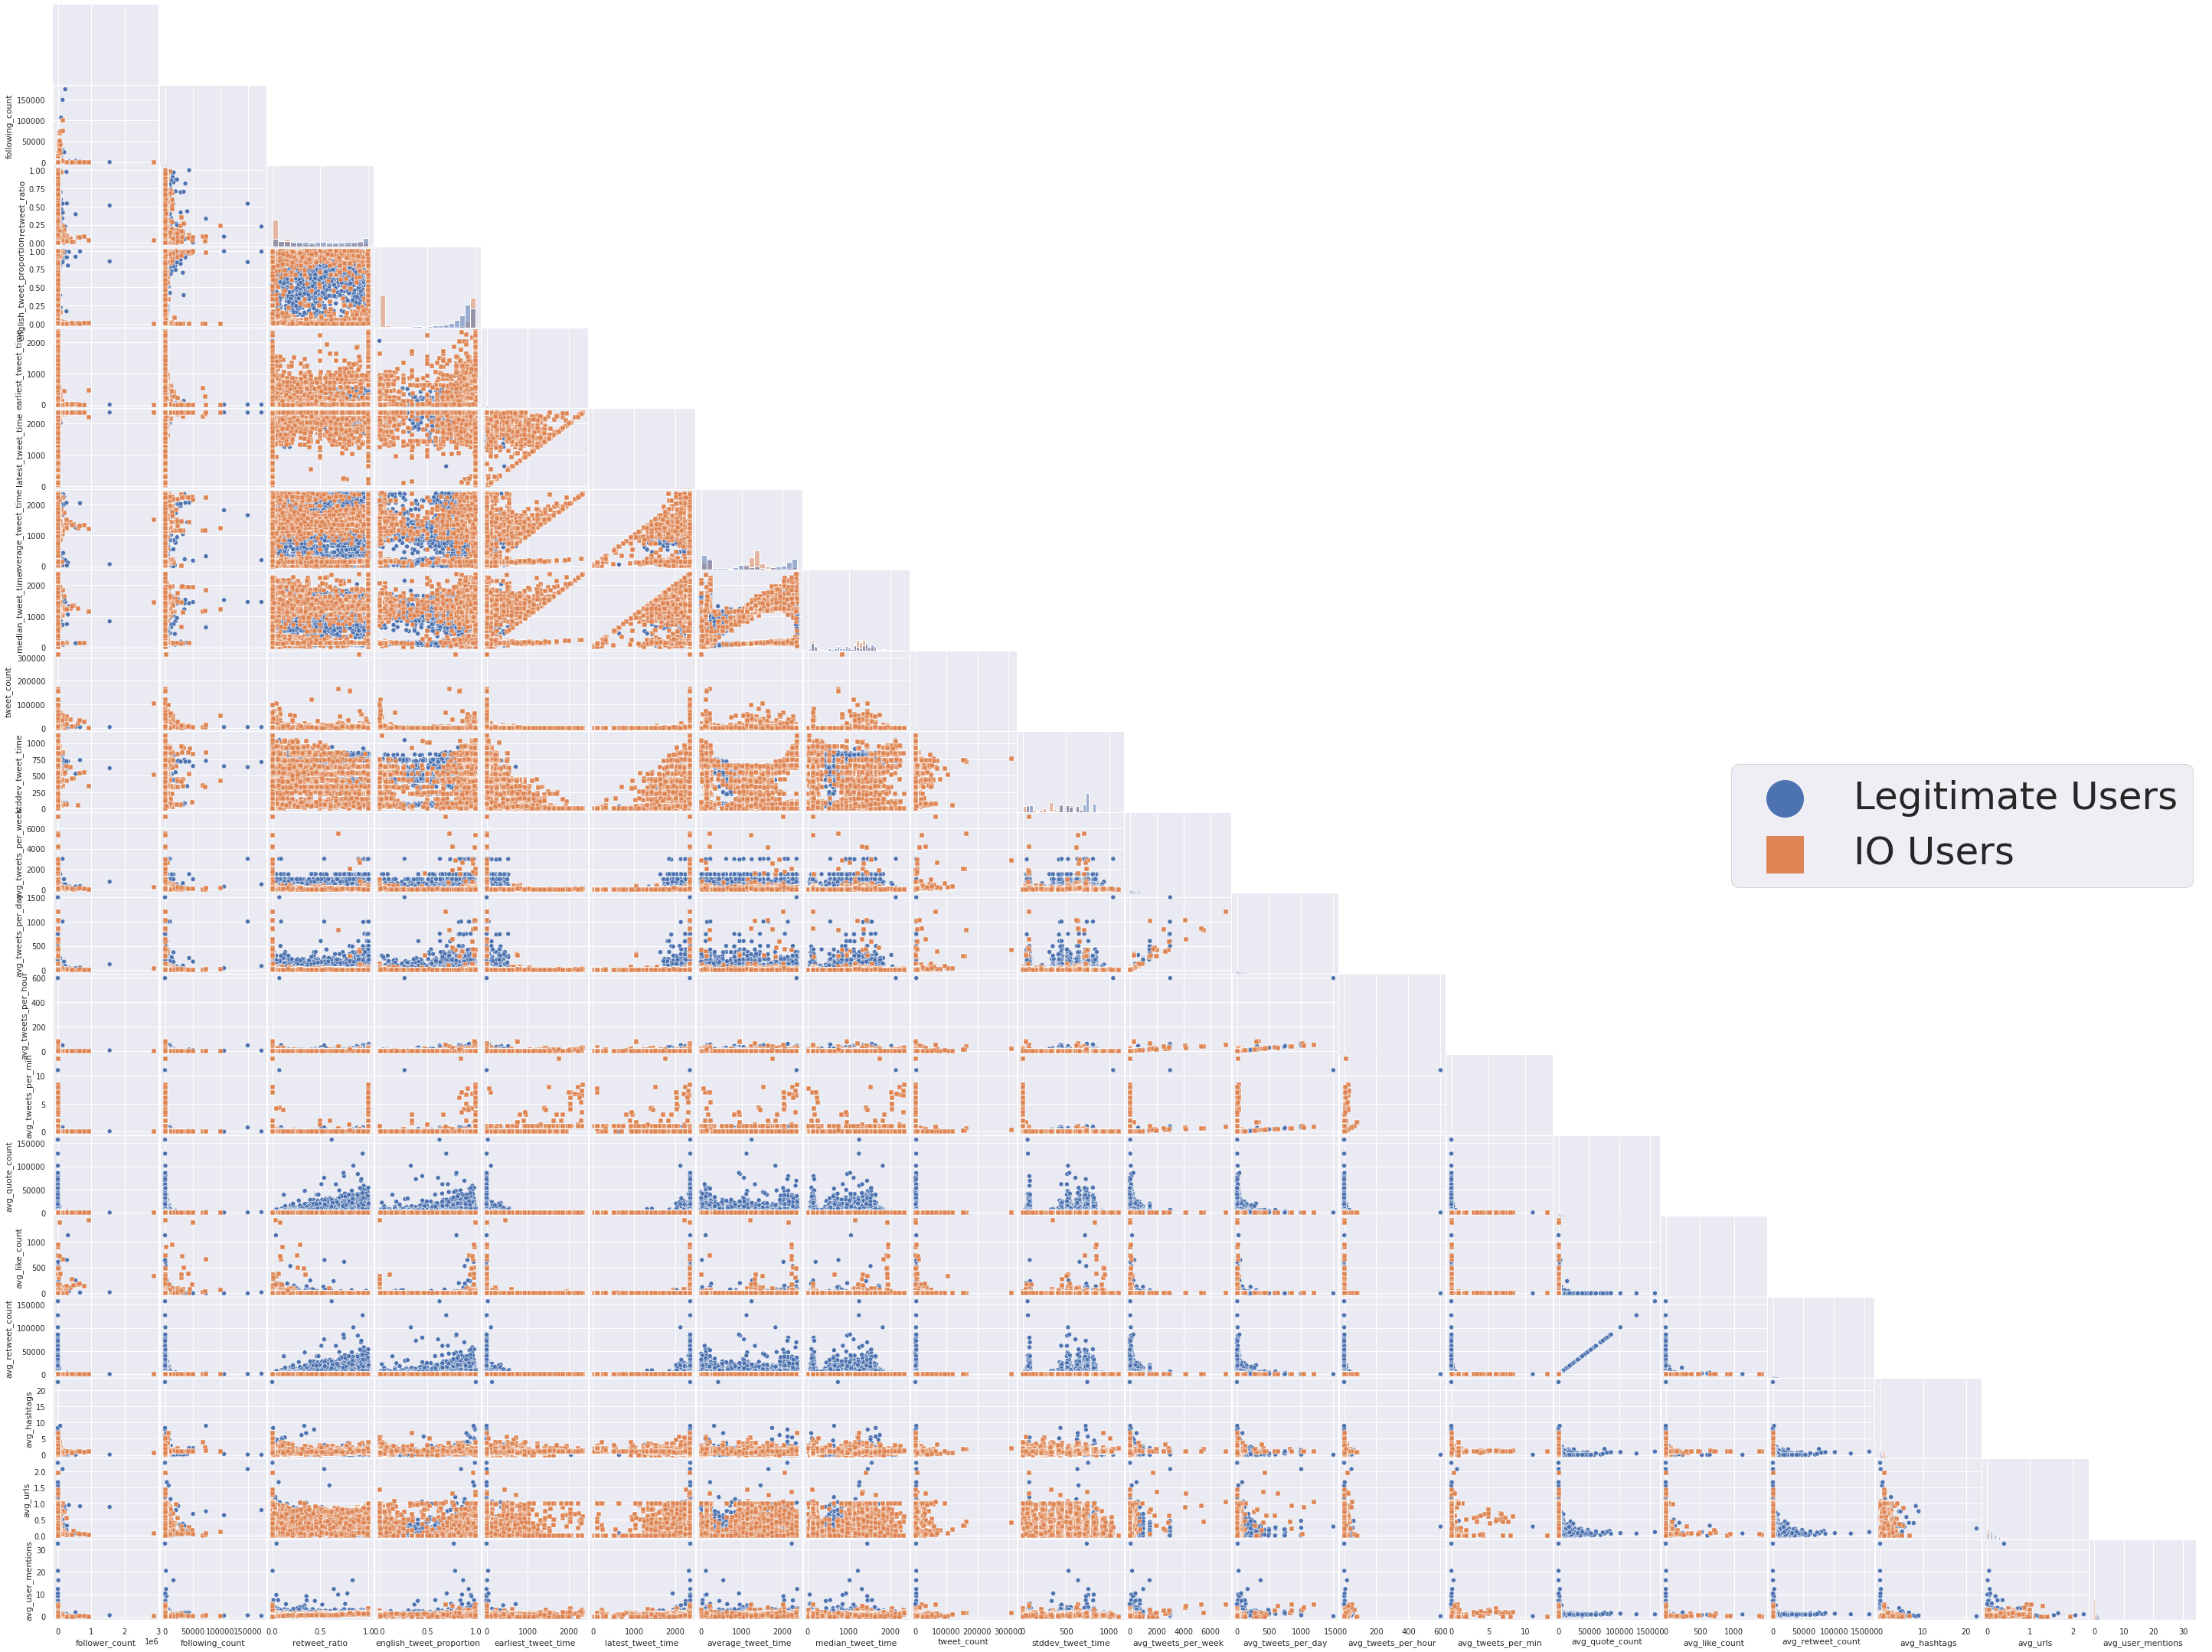

In [14]:
# Plot a scatter matrix for the non-boolean values to see if the data can cluster


sns.set(font_scale=.9)

ax = sns.pairplot(vars=["follower_count","following_count", "retweet_ratio", "english_tweet_proportion","earliest_tweet_time","latest_tweet_time", "average_tweet_time", "median_tweet_time", "tweet_count", "stddev_tweet_time", "avg_tweets_per_week", "avg_tweets_per_day", "avg_tweets_per_hour", "avg_tweets_per_min", "avg_quote_count", "avg_like_count", "avg_retweet_count", "avg_hashtags", "avg_urls",	"avg_user_mentions"], data=all_users, hue="info_op", diag_kind='hist',markers=["o", "s"], corner=True, height = 10, dropna=True)


ax.fig.set_size_inches(40,30)
ax._legend.remove()

handles = ax._legend_data.values()
labels = ['Legitimate Users', 'IO Users']
leg = ax.fig.legend(handles=handles, labels=labels, markerscale=8, fontsize ='50', title_fontsize='50', loc='center right')


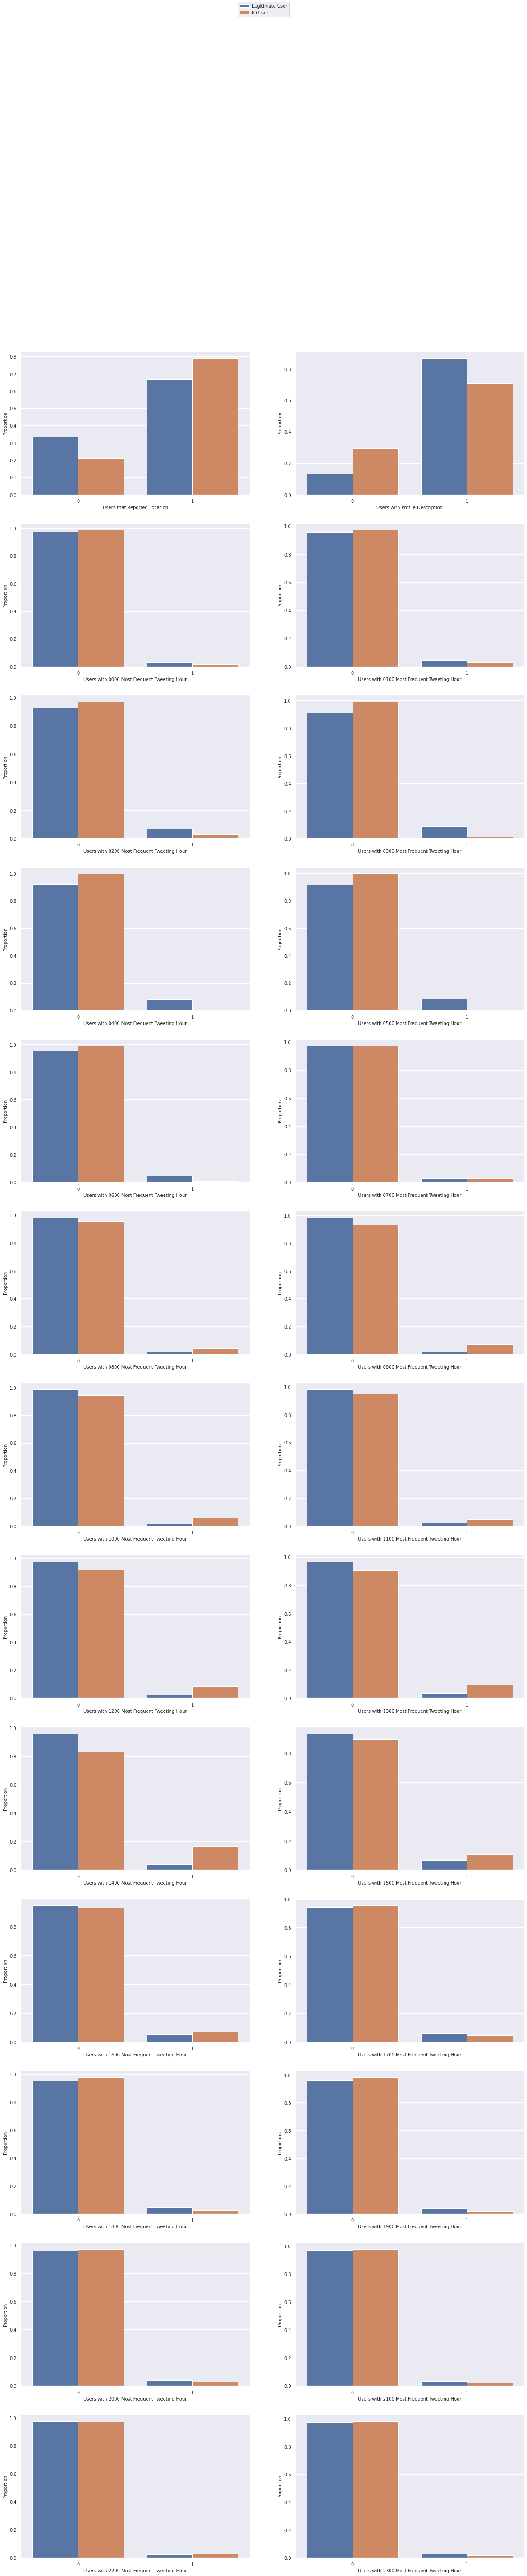

In [15]:
# Plot matrix of bar graphs for the boolean data

figure, axes = plt.subplots(nrows=13, ncols=2, figsize = (20,90))


loc_values = leg_users['user_reported_location'].value_counts(normalize=True)
loc_values = loc_values.to_frame()
loc_values['user_type'] = 'Legitimate User'

disloc_values = dis_users['user_reported_location'].value_counts(normalize=True)
disloc_values = disloc_values.to_frame()
disloc_values['user_type'] = 'IO User'

loc_values = pd.concat([loc_values,disloc_values])
loc_values = loc_values.reset_index()

locplt = sns.barplot(x='index', 
            y='user_reported_location', 
            hue='user_type', 
            data=loc_values, ax=axes[0,0])
locplt.set_xlabel("Users that Reported Location",fontsize=10)
locplt.set_ylabel("Proportion", fontsize=10)
locplt.legend_.remove()


prof_values = leg_users['user_profile_description'].value_counts(normalize=True)
prof_values = prof_values.to_frame()
prof_values['user_type'] = 'Legitimate User'


disprof_values = dis_users['user_profile_description'].value_counts(normalize=True)
disprof_values = disprof_values.to_frame()
disprof_values['user_type'] = 'IO User'

prof_values = pd.concat([prof_values,disprof_values])
prof_values = prof_values.reset_index()

profplt = sns.barplot(x='index', 
            y='user_profile_description', 
            hue='user_type', 
            data=prof_values, ax=axes[0,1])
profplt.set_xlabel("Users with Profile Description",fontsize=10)
profplt.set_ylabel("Proportion", fontsize=10)
profplt.legend_.remove()


mode0_values = leg_users['mode_0'].value_counts(normalize=True)
mode0_values = mode0_values.to_frame()
mode0_values['user_type'] = 'Legitimate User'


dismode0_values = dis_users['mode_0'].value_counts(normalize=True)
dismode0_values = dismode0_values.to_frame()
dismode0_values['user_type'] = 'IO User'

mode0_values = pd.concat([mode0_values,dismode0_values])
mode0_values = mode0_values.reset_index()

mode0plt = sns.barplot(x='index', 
            y='mode_0', 
            hue='user_type', 
            data=mode0_values, ax=axes[1,0])
mode0plt.set_xlabel("Users with 0000 Most Frequent Tweeting Hour",fontsize=10)
mode0plt.set_ylabel("Proportion", fontsize=10)
mode0plt.legend_.remove()


mode1_values = leg_users['mode_1'].value_counts(normalize=True)
mode1_values = mode1_values.to_frame()
mode1_values['user_type'] = 'Legitimate User'


dismode1_values = dis_users['mode_1'].value_counts(normalize=True)
dismode1_values = dismode1_values.to_frame()
dismode1_values['user_type'] = 'IO User'

mode1_values = pd.concat([mode1_values,dismode1_values])
mode1_values = mode1_values.reset_index()

mode1plt = sns.barplot(x='index', 
            y='mode_1', 
            hue='user_type', 
            data=mode1_values, ax=axes[1,1])
mode1plt.set_xlabel("Users with 0100 Most Frequent Tweeting Hour",fontsize=10)
mode1plt.set_ylabel("Proportion", fontsize=10)
mode1plt.legend_.remove()


mode2_values = leg_users['mode_2'].value_counts(normalize=True)
mode2_values = mode2_values.to_frame()
mode2_values['user_type'] = 'Legitimate User'


dismode2_values = dis_users['mode_2'].value_counts(normalize=True)
dismode2_values = dismode2_values.to_frame()
dismode2_values['user_type'] = 'IO User'

mode2_values = pd.concat([mode2_values,dismode2_values])
mode2_values = mode2_values.reset_index()

mode2plt = sns.barplot(x='index', 
            y='mode_2', 
            hue='user_type', 
            data=mode2_values, ax=axes[2,0])
mode2plt.set_xlabel("Users with 0200 Most Frequent Tweeting Hour",fontsize=10)
mode2plt.set_ylabel("Proportion", fontsize=10)
mode2plt.legend_.remove()


mode3_values = leg_users['mode_3'].value_counts(normalize=True)
mode3_values = mode3_values.to_frame()
mode3_values['user_type'] = 'Legitimate User'


dismode3_values = dis_users['mode_3'].value_counts(normalize=True)
dismode3_values = dismode3_values.to_frame()
dismode3_values['user_type'] = 'IO User'

mode3_values = pd.concat([mode3_values,dismode3_values])
mode3_values = mode3_values.reset_index()

mode3plt = sns.barplot(x='index', 
            y='mode_3', 
            hue='user_type', 
            data=mode3_values, ax=axes[2,1])
mode3plt.set_xlabel("Users with 0300 Most Frequent Tweeting Hour",fontsize=10)
mode3plt.set_ylabel("Proportion", fontsize=10)
mode3plt.legend_.remove()


mode4_values = leg_users['mode_4'].value_counts(normalize=True)
mode4_values = mode4_values.to_frame()
mode4_values['user_type'] = 'Legitimate User'


dismode4_values = dis_users['mode_4'].value_counts(normalize=True)
dismode4_values = dismode4_values.to_frame()
dismode4_values['user_type'] = 'IO User'

mode4_values = pd.concat([mode4_values,dismode4_values])
mode4_values = mode4_values.reset_index()

mode4plt = sns.barplot(x='index', 
            y='mode_4', 
            hue='user_type', 
            data=mode4_values, ax=axes[3,0])
mode4plt.set_xlabel("Users with 0400 Most Frequent Tweeting Hour",fontsize=10)
mode4plt.set_ylabel("Proportion", fontsize=10)
mode4plt.legend_.remove()


mode5_values = leg_users['mode_5'].value_counts(normalize=True)
mode5_values = mode5_values.to_frame()
mode5_values['user_type'] = 'Legitimate User'


dismode5_values = dis_users['mode_5'].value_counts(normalize=True)
dismode5_values = dismode5_values.to_frame()
dismode5_values['user_type'] = 'IO User'

mode5_values = pd.concat([mode5_values,dismode5_values])
mode5_values = mode5_values.reset_index()

mode5plt = sns.barplot(x='index', 
            y='mode_5', 
            hue='user_type', 
            data=mode5_values, ax=axes[3,1])
mode5plt.set_xlabel("Users with 0500 Most Frequent Tweeting Hour",fontsize=10)
mode5plt.set_ylabel("Proportion", fontsize=10)
mode5plt.legend_.remove()


mode6_values = leg_users['mode_6'].value_counts(normalize=True)
mode6_values = mode6_values.to_frame()
mode6_values['user_type'] = 'Legitimate User'


dismode6_values = dis_users['mode_6'].value_counts(normalize=True)
dismode6_values = dismode6_values.to_frame()
dismode6_values['user_type'] = 'IO User'

mode6_values = pd.concat([mode6_values,dismode6_values])
mode6_values = mode6_values.reset_index()

mode6plt = sns.barplot(x='index', 
            y='mode_6', 
            hue='user_type', 
            data=mode6_values, ax=axes[4,0])
mode6plt.set_xlabel("Users with 0600 Most Frequent Tweeting Hour",fontsize=10)
mode6plt.set_ylabel("Proportion", fontsize=10)
mode6plt.legend_.remove()


mode7_values = leg_users['mode_7'].value_counts(normalize=True)
mode7_values = mode7_values.to_frame()
mode7_values['user_type'] = 'Legitimate User'


dismode7_values = dis_users['mode_7'].value_counts(normalize=True)
dismode7_values = dismode7_values.to_frame()
dismode7_values['user_type'] = 'IO User'

mode7_values = pd.concat([mode7_values,dismode7_values])
mode7_values = mode7_values.reset_index()

mode7plt = sns.barplot(x='index', 
            y='mode_7', 
            hue='user_type', 
            data=mode7_values, ax=axes[4,1])
mode7plt.set_xlabel("Users with 0700 Most Frequent Tweeting Hour",fontsize=10)
mode7plt.set_ylabel("Proportion", fontsize=10)
mode7plt.legend_.remove()


mode8_values = leg_users['mode_8'].value_counts(normalize=True)
mode8_values = mode8_values.to_frame()
mode8_values['user_type'] = 'Legitimate User'


dismode8_values = dis_users['mode_8'].value_counts(normalize=True)
dismode8_values = dismode8_values.to_frame()
dismode8_values['user_type'] = 'IO User'

mode8_values = pd.concat([mode8_values,dismode8_values])
mode8_values = mode8_values.reset_index()

mode8plt = sns.barplot(x='index', 
            y='mode_8', 
            hue='user_type', 
            data=mode8_values, ax=axes[5,0])
mode8plt.set_xlabel("Users with 0800 Most Frequent Tweeting Hour",fontsize=10)
mode8plt.set_ylabel("Proportion", fontsize=10)
mode8plt.legend_.remove()


mode9_values = leg_users['mode_9'].value_counts(normalize=True)
mode9_values = mode9_values.to_frame()
mode9_values['user_type'] = 'Legitimate User'


dismode9_values = dis_users['mode_9'].value_counts(normalize=True)
dismode9_values = dismode9_values.to_frame()
dismode9_values['user_type'] = 'IO User'

mode9_values = pd.concat([mode9_values,dismode9_values])
mode9_values = mode9_values.reset_index()

mode9plt = sns.barplot(x='index', 
            y='mode_9', 
            hue='user_type', 
            data=mode9_values, ax=axes[5,1])
mode9plt.set_xlabel("Users with 0900 Most Frequent Tweeting Hour",fontsize=10)
mode9plt.set_ylabel("Proportion", fontsize=10)
mode9plt.legend_.remove()


mode10_values = leg_users['mode_10'].value_counts(normalize=True)
mode10_values = mode10_values.to_frame()
mode10_values['user_type'] = 'Legitimate User'


dismode10_values = dis_users['mode_10'].value_counts(normalize=True)
dismode10_values = dismode10_values.to_frame()
dismode10_values['user_type'] = 'IO User'

mode10_values = pd.concat([mode10_values,dismode10_values])
mode10_values = mode10_values.reset_index()

mode10plt = sns.barplot(x='index', 
            y='mode_10', 
            hue='user_type', 
            data=mode10_values, ax=axes[6,0])
mode10plt.set_xlabel("Users with 1000 Most Frequent Tweeting Hour",fontsize=10)
mode10plt.set_ylabel("Proportion", fontsize=10)
mode10plt.legend_.remove()


mode11_values = leg_users['mode_11'].value_counts(normalize=True)
mode11_values = mode11_values.to_frame()
mode11_values['user_type'] = 'Legitimate User'


dismode11_values = dis_users['mode_11'].value_counts(normalize=True)
dismode11_values = dismode11_values.to_frame()
dismode11_values['user_type'] = 'IO User'

mode11_values = pd.concat([mode11_values,dismode11_values])
mode11_values = mode11_values.reset_index()

mode11plt = sns.barplot(x='index', 
            y='mode_11', 
            hue='user_type', 
            data=mode11_values, ax=axes[6,1])
mode11plt.set_xlabel("Users with 1100 Most Frequent Tweeting Hour",fontsize=10)
mode11plt.set_ylabel("Proportion", fontsize=10)
mode11plt.legend_.remove()


mode12_values = leg_users['mode_12'].value_counts(normalize=True)
mode12_values = mode12_values.to_frame()
mode12_values['user_type'] = 'Legitimate User'


dismode12_values = dis_users['mode_12'].value_counts(normalize=True)
dismode12_values = dismode12_values.to_frame()
dismode12_values['user_type'] = 'IO User'

mode12_values = pd.concat([mode12_values,dismode12_values])
mode12_values = mode12_values.reset_index()

mode12plt = sns.barplot(x='index', 
            y='mode_12', 
            hue='user_type', 
            data=mode12_values, ax=axes[7,0])
mode12plt.set_xlabel("Users with 1200 Most Frequent Tweeting Hour",fontsize=10)
mode12plt.set_ylabel("Proportion", fontsize=10)
mode12plt.legend_.remove()


mode13_values = leg_users['mode_13'].value_counts(normalize=True)
mode13_values = mode13_values.to_frame()
mode13_values['user_type'] = 'Legitimate User'


dismode13_values = dis_users['mode_13'].value_counts(normalize=True)
dismode13_values = dismode13_values.to_frame()
dismode13_values['user_type'] = 'IO User'

mode13_values = pd.concat([mode13_values,dismode13_values])
mode13_values = mode13_values.reset_index()

mode13plt = sns.barplot(x='index', 
            y='mode_13', 
            hue='user_type', 
            data=mode13_values, ax=axes[7,1])
mode13plt.set_xlabel("Users with 1300 Most Frequent Tweeting Hour",fontsize=10)
mode13plt.set_ylabel("Proportion", fontsize=10)
mode13plt.legend_.remove()


mode14_values = leg_users['mode_14'].value_counts(normalize=True)
mode14_values = mode14_values.to_frame()
mode14_values['user_type'] = 'Legitimate User'


dismode14_values = dis_users['mode_14'].value_counts(normalize=True)
dismode14_values = dismode14_values.to_frame()
dismode14_values['user_type'] = 'IO User'

mode14_values = pd.concat([mode14_values,dismode14_values])
mode14_values = mode14_values.reset_index()

mode14plt = sns.barplot(x='index', 
            y='mode_14', 
            hue='user_type', 
            data=mode14_values, ax=axes[8,0])
mode14plt.set_xlabel("Users with 1400 Most Frequent Tweeting Hour",fontsize=10)
mode14plt.set_ylabel("Proportion", fontsize=10)
mode14plt.legend_.remove()


mode15_values = leg_users['mode_15'].value_counts(normalize=True)
mode15_values = mode15_values.to_frame()
mode15_values['user_type'] = 'Legitimate User'


dismode15_values = dis_users['mode_15'].value_counts(normalize=True)
dismode15_values = dismode15_values.to_frame()
dismode15_values['user_type'] = 'IO User'

mode15_values = pd.concat([mode15_values,dismode15_values])
mode15_values = mode15_values.reset_index()

mode15plt = sns.barplot(x='index', 
            y='mode_15', 
            hue='user_type', 
            data=mode15_values, ax=axes[8,1])
mode15plt.set_xlabel("Users with 1500 Most Frequent Tweeting Hour",fontsize=10)
mode15plt.set_ylabel("Proportion", fontsize=10)
mode15plt.legend_.remove()


mode16_values = leg_users['mode_16'].value_counts(normalize=True)
mode16_values = mode16_values.to_frame()
mode16_values['user_type'] = 'Legitimate User'


dismode16_values = dis_users['mode_16'].value_counts(normalize=True)
dismode16_values = dismode16_values.to_frame()
dismode16_values['user_type'] = 'IO User'

mode16_values = pd.concat([mode16_values,dismode16_values])
mode16_values = mode16_values.reset_index()

mode16plt = sns.barplot(x='index', 
            y='mode_16', 
            hue='user_type', 
            data=mode16_values, ax=axes[9,0])
mode16plt.set_xlabel("Users with 1600 Most Frequent Tweeting Hour",fontsize=10)
mode16plt.set_ylabel("Proportion", fontsize=10)
mode16plt.legend_.remove()


mode17_values = leg_users['mode_17'].value_counts(normalize=True)
mode17_values = mode17_values.to_frame()
mode17_values['user_type'] = 'Legitimate User'


dismode17_values = dis_users['mode_17'].value_counts(normalize=True)
dismode17_values = dismode17_values.to_frame()
dismode17_values['user_type'] = 'IO User'

mode17_values = pd.concat([mode17_values,dismode17_values])
mode17_values = mode17_values.reset_index()

mode17plt = sns.barplot(x='index', 
            y='mode_17', 
            hue='user_type', 
            data=mode17_values, ax=axes[9,1])
mode17plt.set_xlabel("Users with 1700 Most Frequent Tweeting Hour",fontsize=10)
mode17plt.set_ylabel("Proportion", fontsize=10)
mode17plt.legend_.remove()


mode18_values = leg_users['mode_18'].value_counts(normalize=True)
mode18_values = mode18_values.to_frame()
mode18_values['user_type'] = 'Legitimate User'


dismode18_values = dis_users['mode_18'].value_counts(normalize=True)
dismode18_values = dismode18_values.to_frame()
dismode18_values['user_type'] = 'IO User'

mode18_values = pd.concat([mode18_values,dismode18_values])
mode18_values = mode18_values.reset_index()

mode18plt = sns.barplot(x='index', 
            y='mode_18', 
            hue='user_type', 
            data=mode18_values, ax=axes[10,0])
mode18plt.set_xlabel("Users with 1800 Most Frequent Tweeting Hour",fontsize=10)
mode18plt.set_ylabel("Proportion", fontsize=10)
mode18plt.legend_.remove()


mode19_values = leg_users['mode_19'].value_counts(normalize=True)
mode19_values = mode19_values.to_frame()
mode19_values['user_type'] = 'Legitimate User'


dismode19_values = dis_users['mode_19'].value_counts(normalize=True)
dismode19_values = dismode19_values.to_frame()
dismode19_values['user_type'] = 'IO User'

mode19_values = pd.concat([mode19_values,dismode19_values])
mode19_values = mode19_values.reset_index()

mode19plt = sns.barplot(x='index', 
            y='mode_19', 
            hue='user_type', 
            data=mode19_values, ax=axes[10,1])
mode19plt.set_xlabel("Users with 1900 Most Frequent Tweeting Hour",fontsize=10)
mode19plt.set_ylabel("Proportion", fontsize=10)
mode19plt.legend_.remove()


mode20_values = leg_users['mode_20'].value_counts(normalize=True)
mode20_values = mode20_values.to_frame()
mode20_values['user_type'] = 'Legitimate User'


dismode20_values = dis_users['mode_20'].value_counts(normalize=True)
dismode20_values = dismode20_values.to_frame()
dismode20_values['user_type'] = 'IO User'

mode20_values = pd.concat([mode20_values,dismode20_values])
mode20_values = mode20_values.reset_index()

mode20plt = sns.barplot(x='index', 
            y='mode_20', 
            hue='user_type', 
            data=mode20_values, ax=axes[11,0])
mode20plt.set_xlabel("Users with 2000 Most Frequent Tweeting Hour",fontsize=10)
mode20plt.set_ylabel("Proportion", fontsize=10)
mode20plt.legend_.remove()


mode21_values = leg_users['mode_21'].value_counts(normalize=True)
mode21_values = mode21_values.to_frame()
mode21_values['user_type'] = 'Legitimate User'


dismode21_values = dis_users['mode_21'].value_counts(normalize=True)
dismode21_values = dismode21_values.to_frame()
dismode21_values['user_type'] = 'IO User'

mode21_values = pd.concat([mode21_values,dismode21_values])
mode21_values = mode21_values.reset_index()

mode21plt = sns.barplot(x='index', 
            y='mode_21', 
            hue='user_type', 
            data=mode21_values, ax=axes[11,1])
mode21plt.set_xlabel("Users with 2100 Most Frequent Tweeting Hour",fontsize=10)
mode21plt.set_ylabel("Proportion", fontsize=10)
mode21plt.legend_.remove()


mode22_values = leg_users['mode_22'].value_counts(normalize=True)
mode22_values = mode22_values.to_frame()
mode22_values['user_type'] = 'Legitimate User'


dismode22_values = dis_users['mode_22'].value_counts(normalize=True)
dismode22_values = dismode22_values.to_frame()
dismode22_values['user_type'] = 'IO User'

mode22_values = pd.concat([mode22_values,dismode22_values])
mode22_values = mode22_values.reset_index()

mode22plt = sns.barplot(x='index', 
            y='mode_22', 
            hue='user_type', 
            data=mode22_values, ax=axes[12,0])
mode22plt.set_xlabel("Users with 2200 Most Frequent Tweeting Hour",fontsize=10)
mode22plt.set_ylabel("Proportion", fontsize=10)
mode22plt.legend_.remove()


mode23_values = leg_users['mode_23'].value_counts(normalize=True)
mode23_values = mode23_values.to_frame()
mode23_values['user_type'] = 'Legitimate User'


dismode23_values = dis_users['mode_23'].value_counts(normalize=True)
dismode23_values = dismode23_values.to_frame()
dismode23_values['user_type'] = 'IO User'

mode23_values = pd.concat([mode23_values,dismode23_values])
mode23_values = mode23_values.reset_index()

mode23plt = sns.barplot(x='index', 
            y='mode_23', 
            hue='user_type', 
            data=mode23_values, ax=axes[12,1])
mode23plt.set_xlabel("Users with 2300 Most Frequent Tweeting Hour",fontsize=10)
mode23plt.set_ylabel("Proportion", fontsize=10)
mode23plt.legend_.remove()


handles, labels = mode23plt.get_legend_handles_labels()
legend = figure.legend(handles, labels, loc='upper center')

In [17]:
# Format tweet date information for plotting distribution

# Discard the anomalous dates to not skew data

leg_datetweets = leg_tweets[leg_tweets['info_op'] == 0]
dis_datetweets = dis_tweets[dis_tweets['info_op'] == 1]

leg_datetweets['date'] = leg_datetweets['tweet_time'].dt.strftime('%b-%Y')
dis_datetweets['date'] = dis_datetweets['tweet_time'].dt.strftime('%b-%Y')

legtweetdate_num = leg_datetweets['date'].value_counts()
distweetdate_num = dis_datetweets['date'].value_counts()

legtweetdate_num = legtweetdate_num.reset_index()
distweetdate_num = distweetdate_num.reset_index()

legtweetdate_num = legtweetdate_num.rename(columns={'date':'tweet_num', 'index':'date'})
distweetdate_num = distweetdate_num.rename(columns={'date':'tweet_num', 'index':'date'})

legtweetdate_num['date'] = pd.to_datetime(legtweetdate_num['date'])
distweetdate_num['date'] = pd.to_datetime(distweetdate_num['date'])

legtweetdate_num = legtweetdate_num.sort_values('date')
distweetdate_num = distweetdate_num.sort_values('date')

legtweetdate_num['date'] = legtweetdate_num['date'].dt.strftime('%b-%Y')
distweetdate_num['date'] = distweetdate_num['date'].dt.strftime('%b-%Y')

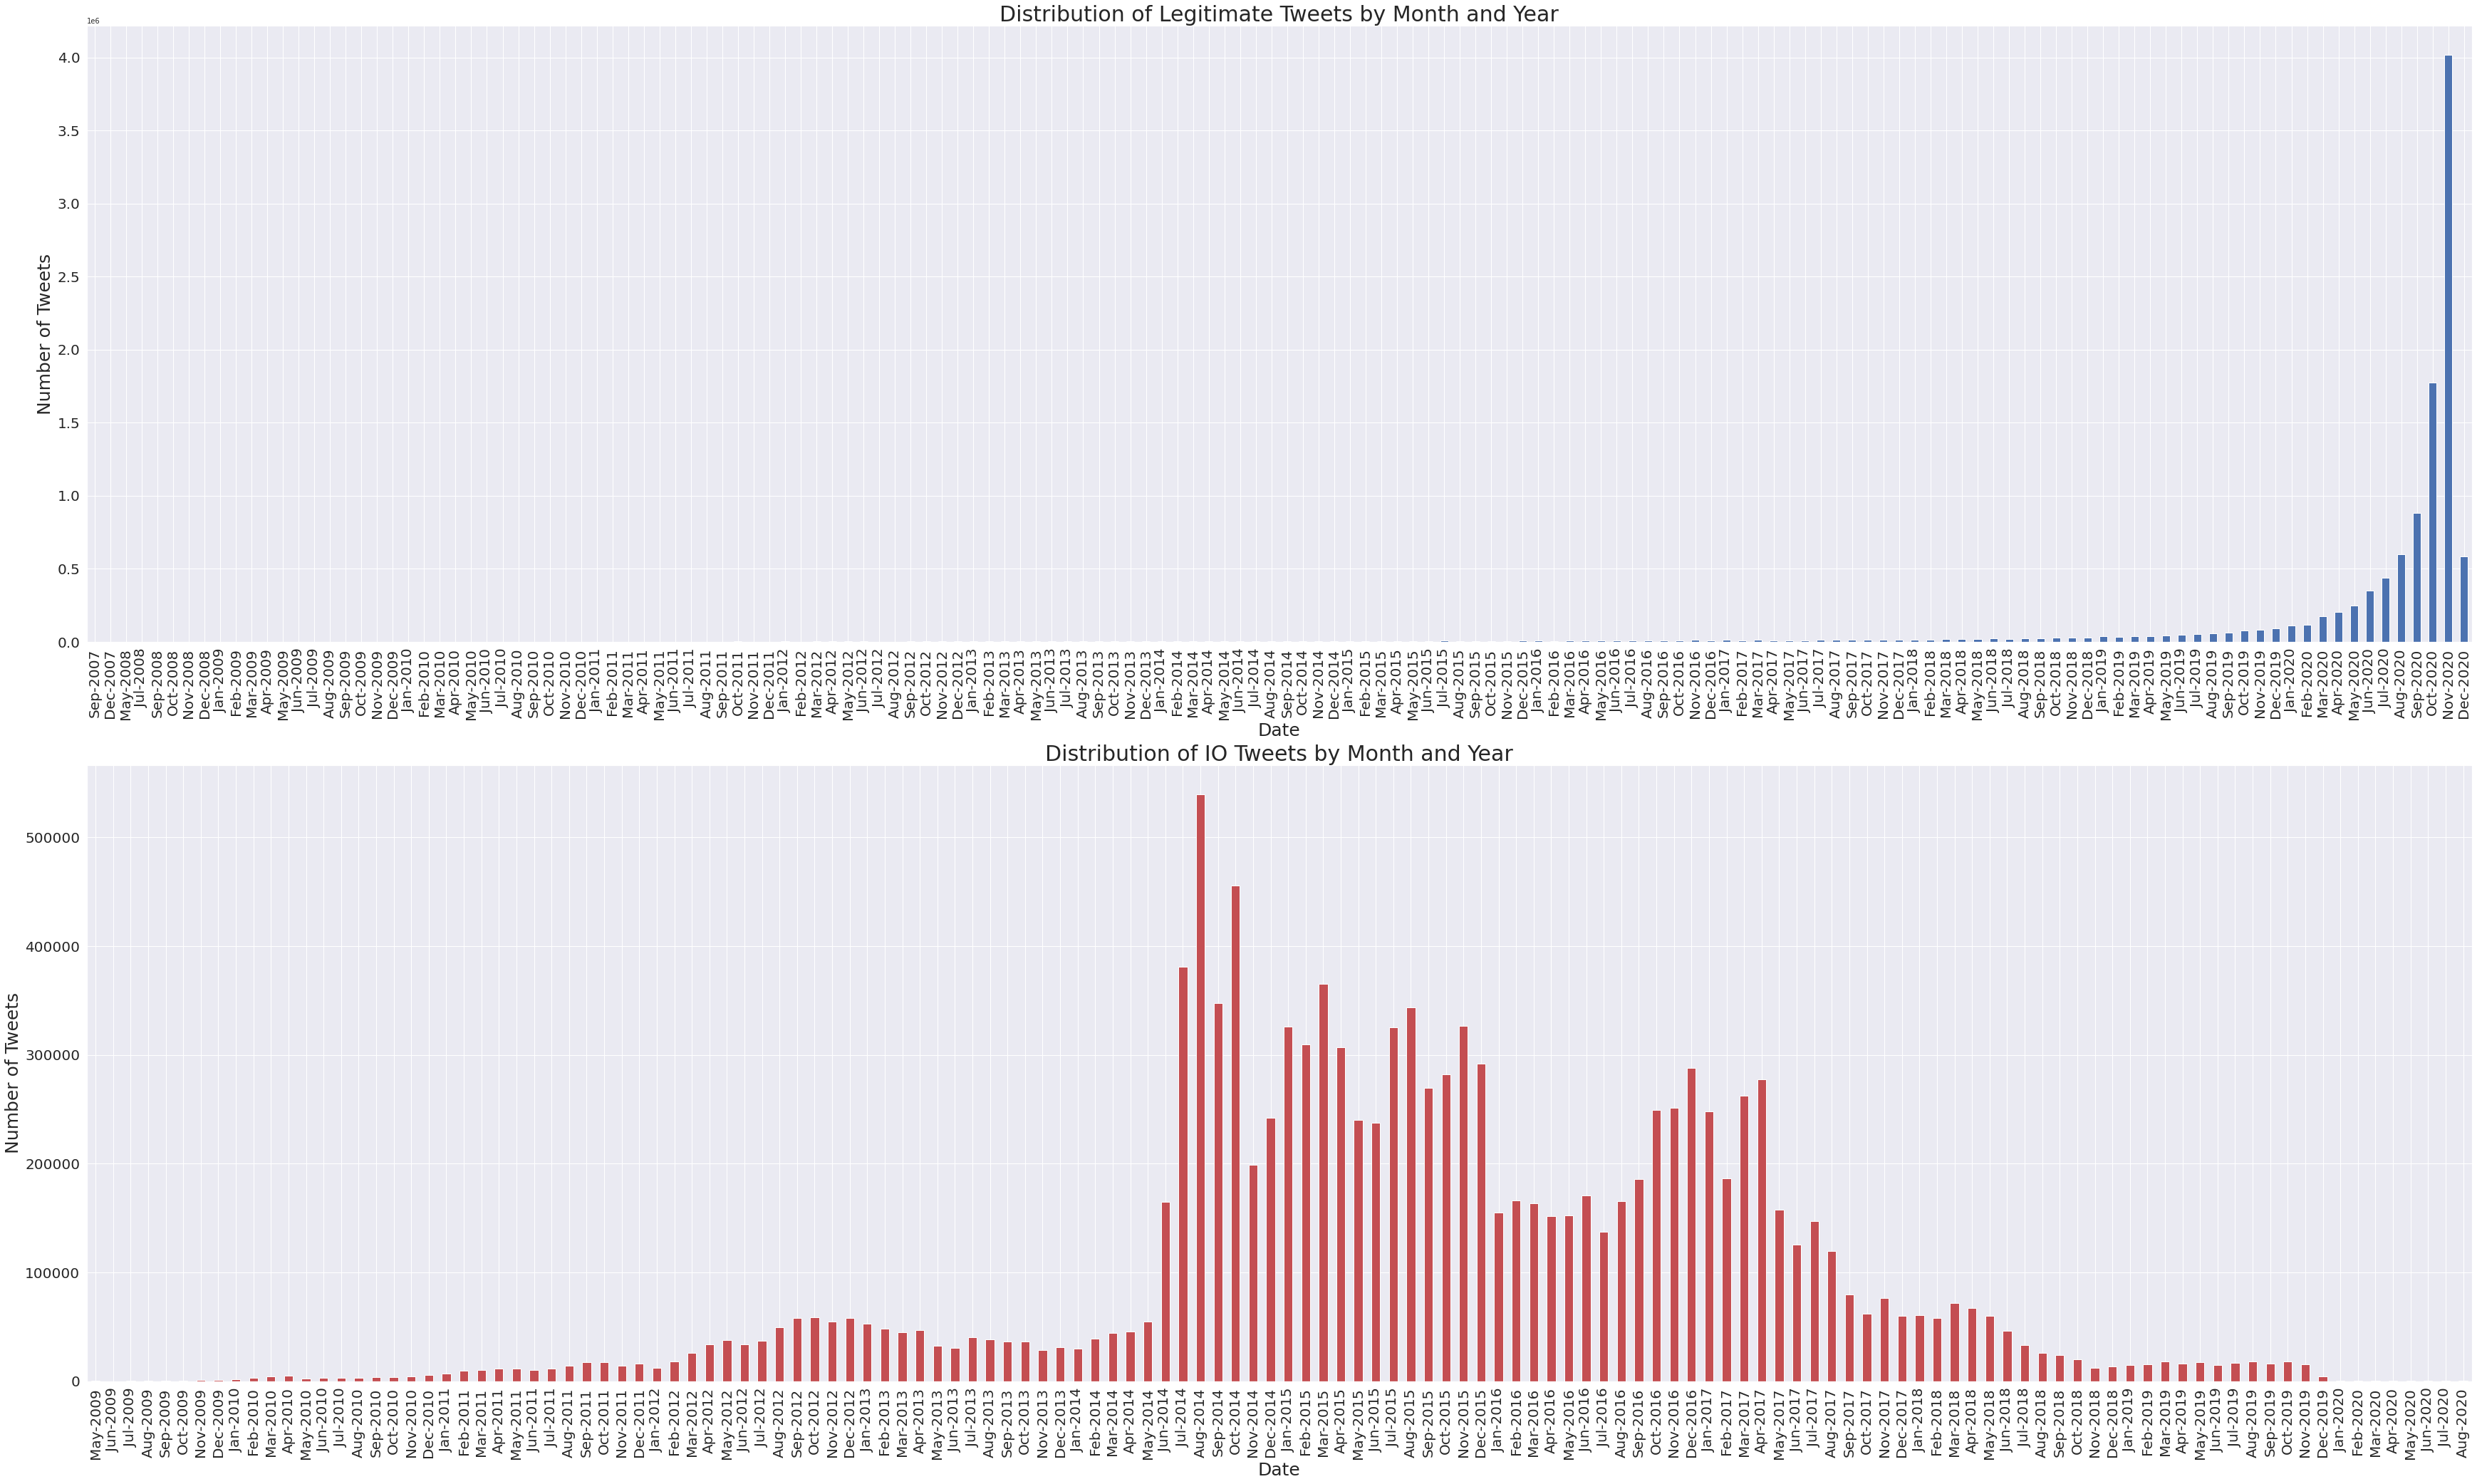

In [18]:
# Plot number of tweets by date

figure, axes = plt.subplots(nrows=2, ncols=1, figsize = (60,35))

legtweetplt = legtweetdate_num.plot.bar(x='date', y='tweet_num', ax=axes[0], color='b', fontsize=20)
legtitle = legtweetplt.set_title('Distribution of Legitimate Tweets by Month and Year', fontsize=30)
legxlab = legtweetplt.set_xlabel("Date",fontsize=25)
legylab = legtweetplt.set_ylabel('Number of Tweets', fontsize=25)
leglegendremove = legtweetplt.legend_.remove()

distweetplt = distweetdate_num.plot.bar(x='date', y='tweet_num', ax=axes[1], color='r', fontsize=20)
distitle = distweetplt.set_title('Distribution of IO Tweets by Month and Year', fontsize=30)
disxlab = distweetplt.set_xlabel("Date",fontsize=25)
disylab = distweetplt.set_ylabel('Number of Tweets', fontsize=25)
dislegendremove = distweetplt.legend_.remove()

Due to the nature by which the tweets were scraped and the method by which Twitter releases influence operation datasets, the majority of tweets for the legitimate users are from 2020 while the majority of tweets from IO users are from 2014-2017. We attempted to account for this by querying legitimate users using keyword topics derived from the information operations users so there is not an artificial clustering difference as a result of different discussion topics during these different time periods.

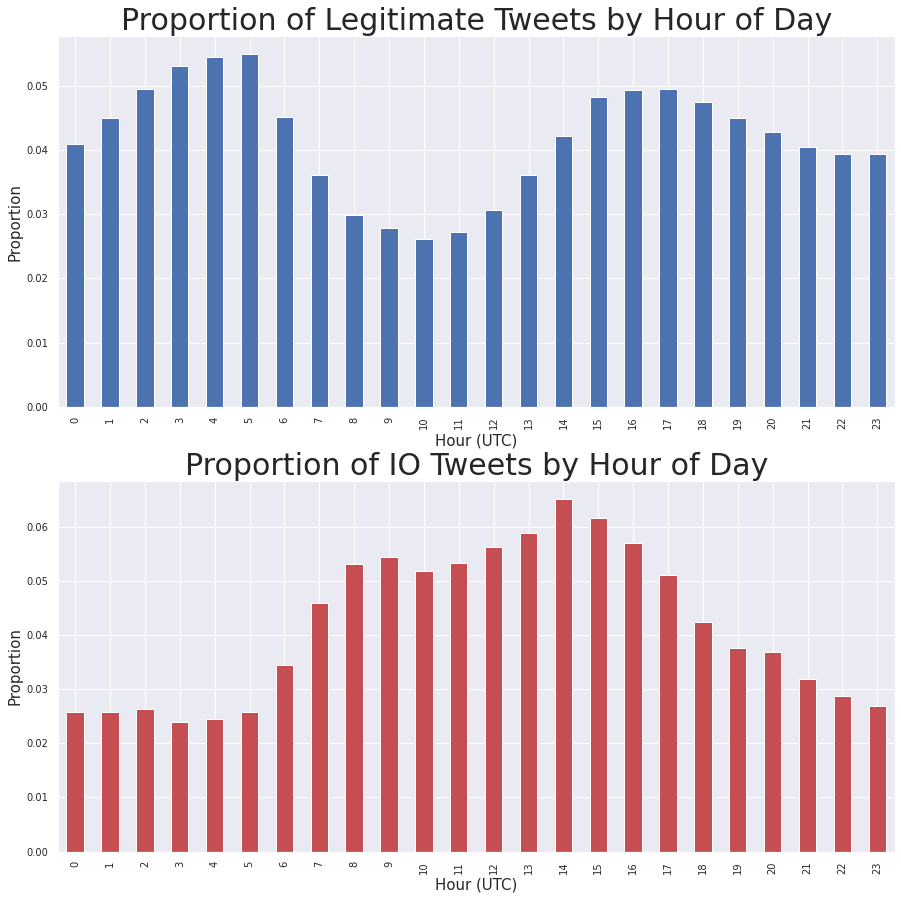

In [20]:
# Plot time histograms for proportion of tweets between two datasets

# Discard dummy date for tweets that had this section as null

leg_timetweets = leg_tweets[leg_tweets['info_op'] == 0]
dis_timetweets = dis_tweets[dis_tweets['info_op'] == 1]


leg_timetweets['hour'] = [d.hour for d in leg_timetweets['tweet_time']]

leg_tweets_hour_proportion = leg_timetweets['hour'].value_counts(normalize=True)

leg_tweets_hour_proportion = leg_tweets_hour_proportion.sort_index()

dis_timetweets['hour'] = [d.hour for d in dis_timetweets['tweet_time']]

dis_tweets_hour_proportion = dis_timetweets['hour'].value_counts(normalize=True)

dis_tweets_hour_proportion = dis_tweets_hour_proportion.sort_index()

figure, axes = plt.subplots(nrows=2, ncols=1, figsize = (15,15))

legtweetplt = leg_tweets_hour_proportion.plot.bar(ax=axes[0], color='b')
legtweetplt.set_title('Proportion of Legitimate Tweets by Hour of Day', fontsize=30)
legtweetplt.set_xlabel("Hour (UTC)",fontsize=15)
legtweetplt.set_ylabel('Proportion', fontsize=15)

distweetplt = dis_tweets_hour_proportion.plot.bar(ax=axes[1], color='r')
distweetplt.set_title('Proportion of IO Tweets by Hour of Day', fontsize=30)
xlab = distweetplt.set_xlabel("Hour (UTC)",fontsize=15)
ylab = distweetplt.set_ylabel('Proportion', fontsize=15)

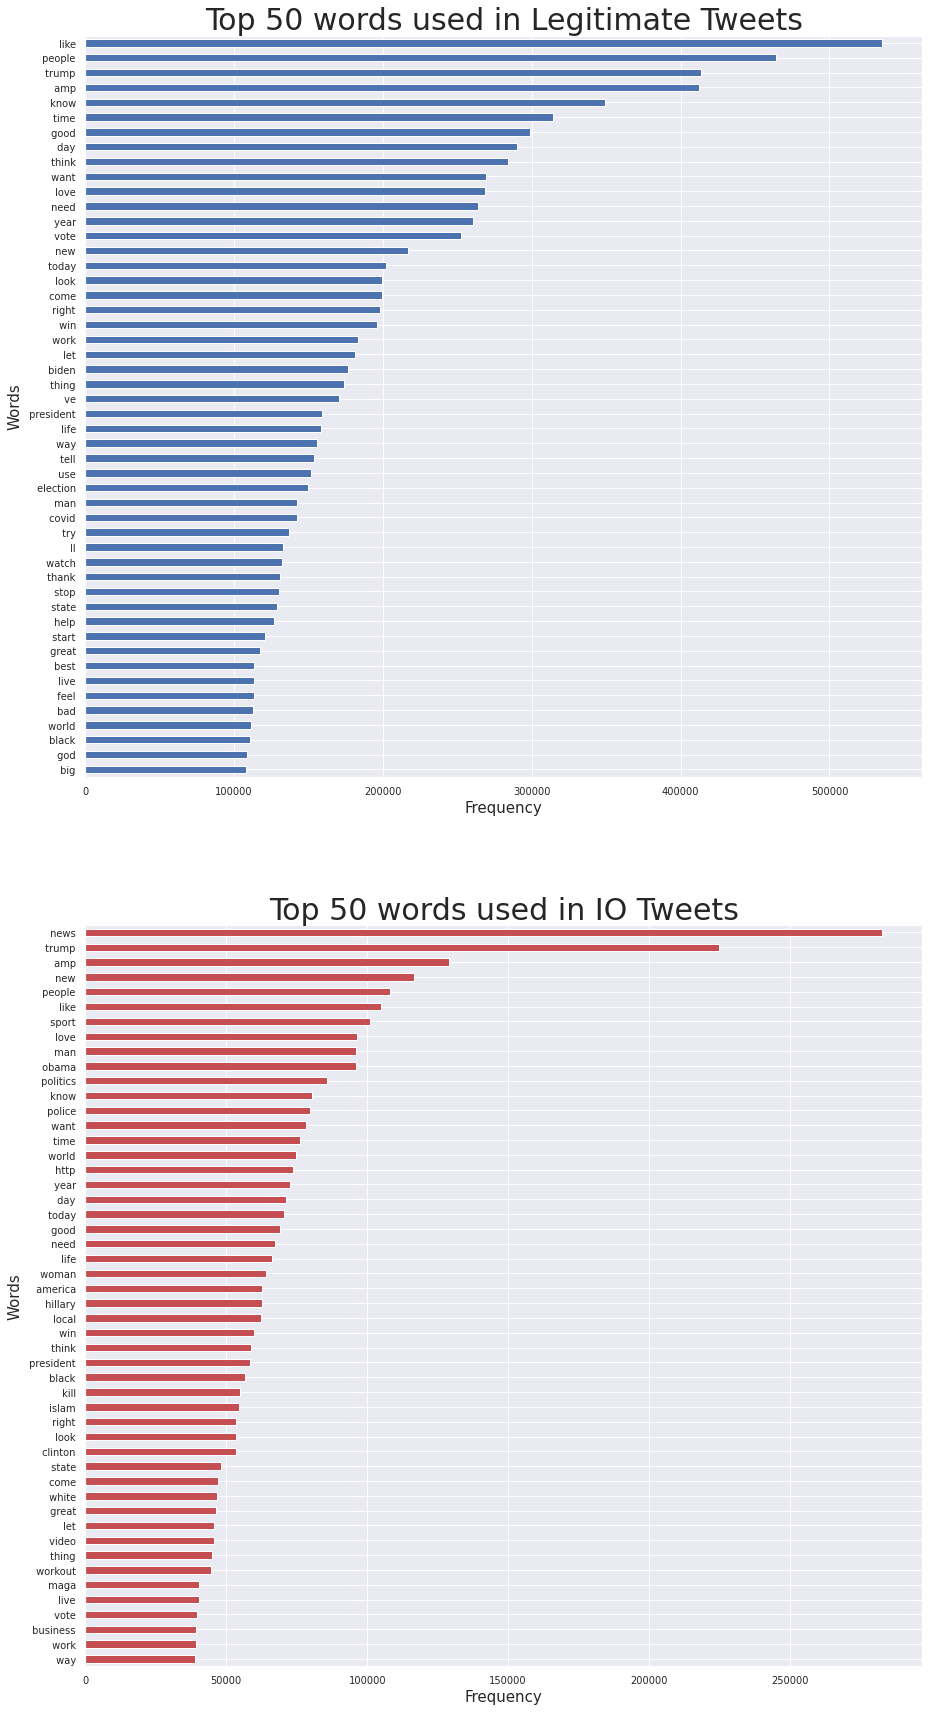

In [ ]:
# Get 50 most used words in legitimate user dataset, first word is an empty space so skip

BoW_leg_list = leg_users['BoW'].str.replace("'",'')
BoW_leg_list = BoW_leg_list[BoW_leg_list.notnull()].apply(lambda x: x.strip('][').split(','))
BoW_leg_list = list(itertools.chain.from_iterable(BoW_leg_list))
BoW_leg_list = pd.Series(BoW_leg_list)
BoW_leg_list = BoW_leg_list.value_counts()
top_leg_words = BoW_leg_list[:50]
top_leg_words = top_leg_words.reindex(index=top_leg_words.index[::-1])


# Get 50 most used words in disinformation user dataset, first word is an empty space so skip

BoW_dis_list = dis_users['BoW'].str.replace("'",'')
BoW_dis_list = BoW_dis_list[BoW_dis_list.notnull()].apply(lambda x: x.strip('][').split(','))
BoW_dis_list = list(itertools.chain.from_iterable(BoW_dis_list))
BoW_dis_list = pd.Series(BoW_dis_list)
BoW_dis_list = BoW_dis_list.value_counts()
top_dis_words = BoW_dis_list[:50]
top_dis_words = top_dis_words.reindex(index=top_dis_words.index[::-1])


# Create bar plots

figure, axes = plt.subplots(nrows=2, ncols=1, figsize = (15,30))

legwordplt = top_leg_words.plot.barh(ax=axes[0], color='b')
legtitle = legwordplt.set_title('Top 50 words used in Legitimate Tweets', fontsize=30)
legy = legwordplt.set_ylabel("Words",fontsize=15)
legx = legwordplt.set_xlabel('Frequency', fontsize=15)

diswordplt = top_dis_words.plot.barh(ax=axes[1], color='r')
distitle = diswordplt.set_title('Top 50 words used in IO Tweets', fontsize=30)
disy = diswordplt.set_ylabel("Words",fontsize=15)
disx = diswordplt.set_xlabel('Frequency', fontsize=15)

Now we will train various models on the user datasets and see which ones have the best performance. We will start by making models with the BoW data for each user

In [ ]:
# Format BoW data into strings rather than a list of lists for the vectorizers

BoW_df = all_users[["BoW", "info_op"]]

# Use if above cell that plots top 50 words has not been run to convert strings to lists
BoW_model_list = BoW_df['BoW'].str.replace("'", '')
BoW_model_list = BoW_model_list.str.replace(",", '')
BoW_df['BoW'] = BoW_model_list[BoW_model_list.notnull()].apply(lambda x: x.strip(']['))

# Perform train test split on BoW data

X_BoW = BoW_df['BoW']
y_BoW = BoW_df["info_op"]

X_BoW_train, X_BoW_test, y_BoW_train, y_BoW_test = train_test_split(X_BoW, y_BoW, test_size=0.20, random_state=42)

In [ ]:
# Perform TFIDF vectorization on data

tfidf_vectorizer = TfidfVectorizer()

X_BoW_tfidf_train = tfidf_vectorizer.fit_transform(X_BoW_train)
X_BoW_tfidf_test = tfidf_vectorizer.transform(X_BoW_test)

In [ ]:
# Fit Multinomial Naive Bayes on TFIDF vectorization with GridSearchCV

mnb_tfidf_grid_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False],
}

mnb_tfidf_grid = GridSearchCV(MultinomialNB(), mnb_tfidf_grid_params, cv=5, verbose=2)

mnb_tfidf_grid.fit(X_BoW_tfidf_train, y_BoW_train)

print("\n\nBest MNB with TFIDF Score: ", mnb_tfidf_grid.best_score_)
print("Best MNB with TFIDF Params: ", mnb_tfidf_grid.best_params_)

y_mnb_tfidf_predict = mnb_tfidf_grid.predict(X_BoW_tfidf_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] alpha=0.5, fit_prior=True .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ alpha=0.5, fit_prior=True, total=   0.3s
[CV] alpha=0.5, fit_prior=True .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ........................ alpha=0.5, fit_prior=True, total=   0.3s
[CV] alpha=0.5, fit_prior=True .......................................
[CV] ........................ alpha=0.5, fit_prior=True, total=   0.3s
[CV] alpha=0.5, fit_prior=True .......................................
[CV] ........................ alpha=0.5, fit_prior=True, total=   0.3s
[CV] alpha=0.5, fit_prior=True .......................................
[CV] ........................ alpha=0.5, fit_prior=True, total=   0.3s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] ....................... alpha=0.5, fit_prior=False, total=   0.3s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] ....................... alpha=0.5, fit_prior=False, total=   0.3s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] ....................... alpha=0.5, fit_prior=False, total=   0.3s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   18.6s finished




Best MNB with TFIDF Score:  0.7469090909090909
Best MNB with TFIDF Params:  {'alpha': 0.5, 'fit_prior': False}


In [ ]:
# Create grid search parameters for SGD and TFIDF
sgd_tfidf_grid_params = { 
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
  'penalty': ["none", "l1", "l2"],
  'eta0': [0.001, 0.01, 0.1, 1, 10, 100],
  'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# Perform Grid Search on SGD with TFIDF vectorizer
sgd_tfidf_grid = GridSearchCV(SGDClassifier(random_state=42), sgd_tfidf_grid_params, cv=5, n_jobs=-1, verbose=2)
sgd_tfidf_grid.fit(X_BoW_tfidf_train, y_BoW_train)
print("\n\nBest SGD with TFIDF Score: ", sgd_tfidf_grid.best_score_)
print("Best SGD with TFIDF Params: ", sgd_tfidf_grid.best_params_)


# Perform prediction on test data
y_sgd_tfidf_predict = sgd_tfidf_grid.predict(X_BoW_tfidf_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1378 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 58.1min finished




Best SGD with TFIDF Score:  0.9755636363636363
Best SGD with TFIDF Params:  {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive', 'penalty': 'none'}


In [ ]:
# Perform count vectorization on data

cv_vectorizer = CountVectorizer()

X_BoW_cv_train = cv_vectorizer.fit_transform(X_BoW_train)
X_BoW_cv_test = cv_vectorizer.transform(X_BoW_test)

In [ ]:
# Fit Multinomial Naive Bayes on CV vectorization with GridSearchCV

mnb_cv_grid_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False],
}

mnb_cv_grid = GridSearchCV(MultinomialNB(), mnb_cv_grid_params, cv=5, verbose=2)

mnb_cv_grid.fit(X_BoW_cv_train, y_BoW_train)

print("\n\nBest MNB with CV Score: ", mnb_cv_grid.best_score_)
print("Best MNB with CV Params: ", mnb_cv_grid.best_params_)

y_mnb_cv_predict = mnb_cv_grid.predict(X_BoW_cv_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] alpha=0.5, fit_prior=True .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................ alpha=0.5, fit_prior=True, total=   0.4s
[CV] alpha=0.5, fit_prior=True .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ........................ alpha=0.5, fit_prior=True, total=   0.4s
[CV] alpha=0.5, fit_prior=True .......................................
[CV] ........................ alpha=0.5, fit_prior=True, total=   0.4s
[CV] alpha=0.5, fit_prior=True .......................................
[CV] ........................ alpha=0.5, fit_prior=True, total=   0.4s
[CV] alpha=0.5, fit_prior=True .......................................
[CV] ........................ alpha=0.5, fit_prior=True, total=   0.4s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] ....................... alpha=0.5, fit_prior=False, total=   0.4s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] ....................... alpha=0.5, fit_prior=False, total=   0.4s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] ....................... alpha=0.5, fit_prior=False, total=   0.4s
[CV] alpha=0.5, fit_prior=False ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   22.7s finished




Best MNB with CV Score:  0.8935272727272727
Best MNB with CV Params:  {'alpha': 0.5, 'fit_prior': False}


In [ ]:
# Fit SGD Classifier on CV vectorization with GridSearchCV

sgd_cv_grid_params = { 
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
  'penalty': ["none", "l1", "l2"],
  'eta0': [0.001, 0.01, 0.1, 1, 10, 100],
  'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# Perform Grid Search on SGD with cv vectorizer
sgd_cv_grid = GridSearchCV(SGDClassifier(random_state=42), sgd_cv_grid_params, cv=5, n_jobs=-1, verbose=2)
sgd_cv_grid.fit(X_BoW_cv_train, y_BoW_train)
print("\n\nBest SGD with CV Score: ", sgd_cv_grid.best_score_)
print("Best SGD with CV Params: ", sgd_cv_grid.best_params_)


# Perform prediction on test data
y_sgd_cv_predict = sgd_cv_grid.predict(X_BoW_cv_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed: 72.8min
[Parallel(n_jobs=-1)]: Done 1378 tasks      | elapsed: 101.3min
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed: 130.4min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed: 168.0min finished




Best SGD with CV Score:  0.984
Best SGD with CV Params:  {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'adaptive', 'penalty': 'l2'}


In [ ]:
# Compare performance of the SVM and MultinomialNB with TFIDF and Count Vectorizer and Choose the highest performing
# One to use with the ensemble function

# MultinomialNB with BoW Metrics
print('Multinomial Naive Bayes with TFIDF\n')
print('Accuracy: ', accuracy_score(y_BoW_test, y_mnb_tfidf_predict))
print('Precision: ', precision_score(y_BoW_test, y_mnb_tfidf_predict))
print('Recall: ', recall_score(y_BoW_test, y_mnb_tfidf_predict))
print('F1 Score:',f1_score(y_BoW_test, y_mnb_tfidf_predict))
print('\n')

# Stochastic Gradient Descent Classifier with TFIDF
print('Stochastic Gradient Descent Classifier with TFIDF\n')
print('Accuracy: ', accuracy_score(y_BoW_test, y_sgd_tfidf_predict))
print('Precision: ', precision_score(y_BoW_test, y_sgd_tfidf_predict))
print('Recall: ', recall_score(y_BoW_test, y_sgd_tfidf_predict))
print('F1 Score:',f1_score(y_BoW_test, y_sgd_tfidf_predict))
print('\n')

# Multinomial Naive Bayes with Count Vectorizer
print('Multinomial Naive Bayes with Count Vectorizer\n')
print('Accuracy: ', accuracy_score(y_BoW_test, y_mnb_cv_predict))
print('Precision: ', precision_score(y_BoW_test, y_mnb_cv_predict))
print('Recall: ', recall_score(y_BoW_test, y_mnb_cv_predict))
print('F1 Score:',f1_score(y_BoW_test, y_mnb_cv_predict))
print('\n')

# Stochastic Gradient Descent with Count Vectorizer
print('Stochastic Gradient Descent with Count Vectorizer\n')
print('Accuracy: ', accuracy_score(y_BoW_test, y_sgd_cv_predict))
print('Precision: ', precision_score(y_BoW_test, y_sgd_cv_predict))
print('Recall: ', recall_score(y_BoW_test, y_sgd_cv_predict))
print('F1 Score:',f1_score(y_BoW_test, y_sgd_cv_predict))

Multinomial Naive Bayes with TFIDF

Accuracy:  0.7655613728912158
Precision:  0.9976798143851509
Recall:  0.5168269230769231
F1 Score: 0.6809184481393509


Stochastic Gradient Descent Classifier with TFIDF

Accuracy:  0.9813845258871436
Precision:  0.977326968973747
Recall:  0.984375
F1 Score: 0.9808383233532934


Multinomial Naive Bayes with Count Vectorizer

Accuracy:  0.8987783595113438
Precision:  0.9838235294117647
Recall:  0.8040865384615384
F1 Score: 0.8849206349206349


Stochastic Gradient Descent with Count Vectorizer

Accuracy:  0.9825479930191972
Precision:  0.972877358490566
Recall:  0.9915865384615384
F1 Score: 0.9821428571428571


The Stochastic Gradient Descent model outperformed the Multinomial Naive Bayes model with both the Count Vectorizer and TFIDF. Both SGD models have relatively comparable metrics.

In [ ]:
# Save prediction results to CSV

y_mnb_tfidf_predict = pd.Series(y_mnb_tfidf_predict)
y_mnb_tfidf_predict.to_csv('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/y_mnb_tfidf_predict_series.csv', index=False)

y_sgd_tfidf_predict = pd.Series(y_sgd_tfidf_predict)
y_sgd_tfidf_predict.to_csv('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/y_sgd_tfidf_predict_series.csv', index=False)

y_mnb_cv_predict = pd.Series(y_mnb_cv_predict)
y_mnb_cv_predict.to_csv('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/y_mnb_cv_predict_series.csv', index=False)

y_sgd_cv_predict = pd.Series(y_sgd_cv_predict)
y_sgd_cv_predict.to_csv('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/y_sgd_cv_predict_series.csv', index=False)


In [ ]:
# Save models to files

pickle.dump(mnb_tfidf_grid, open('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Models_Step4/mnb_tfidf_model.sav', 'wb'))
pickle.dump(sgd_tfidf_grid, open('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Models_Step4/sgd_tfidf_model.sav', 'wb'))
pickle.dump(mnb_cv_grid, open('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Models_Step4/mnb_cv_model.sav', 'wb'))
pickle.dump(sgd_cv_grid, open('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions/sgd_cv_model.sav', 'wb'))

Now we will see how a Multilayer Perceptron Network performs on the BoW data with Count Vectorization. 

Unfortunately, the data in its current form is much too large to create a neural network with the available RAM we have in Google Colab Pro. So we will take a random subset of the datasets and create the neural network from those.





In [ ]:
# Grab random rows from the train test datasets

train_number_of_rows = X_BoW_train.shape[0]
test_number_of_rows = X_BoW_test.shape[0]

np.random.seed(42)
random_train_indices = np.random.choice(train_number_of_rows, size=round(train_number_of_rows/3), replace=False)
random_test_indices = np.random.choice(test_number_of_rows, size=round(test_number_of_rows/3), replace=False)

X_BoW_cv_train_nn = X_BoW_train.take(random_train_indices)
y_BoW_train_nn = y_BoW_train.take(random_train_indices)

X_BoW_cv_test_nn = X_BoW_test.take(random_test_indices)
y_BoW_test_nn = y_BoW_test.take(random_test_indices)

X_BoW_cv_train_nn.shape, X_BoW_cv_test_nn.shape, y_BoW_train_nn.shape, y_BoW_test_nn.shape

((2292,), (573,), (2292,), (573,))

In [ ]:
# Vectorize the data

X_BoW_cv_train_nn = cv_vectorizer.fit_transform(X_BoW_cv_train_nn)
X_BoW_cv_test_nn = cv_vectorizer.transform(X_BoW_cv_test_nn)

X_BoW_cv_train_nn.shape, X_BoW_cv_test_nn.shape

((2292, 454315), (573, 454315))

In [ ]:
# format data for input to Neural Networks

X_BoW_cv_train_nn = X_BoW_cv_train_nn.toarray()
X_BoW_cv_test_nn = X_BoW_cv_test_nn.toarray()

y_BoW_train_nn = y_BoW_train_nn.to_numpy()
y_BoW_test_nn = y_BoW_test_nn.to_numpy()

X_BoW_cv_train_nn.shape, X_BoW_cv_test_nn.shape, y_BoW_train_nn.shape, y_BoW_test_nn.shape

((2292, 454315), (573, 454315), (2292,), (573,))

In [ ]:
# Function to help plot graphs

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Epoch 1/100
72/72 [==============================] - 10s 134ms/step - loss: 1.0950 - accuracy: 0.8940 - val_loss: 0.3607 - val_accuracy: 0.9738
Epoch 2/100
72/72 [==============================] - 10s 138ms/step - loss: 0.1618 - accuracy: 0.9756 - val_loss: 0.1960 - val_accuracy: 0.9215
Epoch 3/100
72/72 [==============================] - 10s 138ms/step - loss: 0.2403 - accuracy: 0.9891 - val_loss: 0.2039 - val_accuracy: 0.9843
Epoch 4/100
72/72 [==============================] - 10s 139ms/step - loss: 0.5391 - accuracy: 0.9852 - val_loss: 0.7710 - val_accuracy: 0.9738
Epoch 5/100
72/72 [==============================] - 10s 135ms/step - loss: 0.0236 - accuracy: 0.9983 - val_loss: 0.8682 - val_accuracy: 0.9843
Epoch 6/100
72/72 [==============================] - 10s 136ms/step - loss: 0.0387 - accuracy: 0.9974 - val_loss: 1.3308 - val_accuracy: 0.9791
Epoch 7/100
72/72 [==============================] - 10s 135ms/step - loss: 0.1552 - accuracy: 0.9974 - val_loss: 0.6623 - val_accuracy:

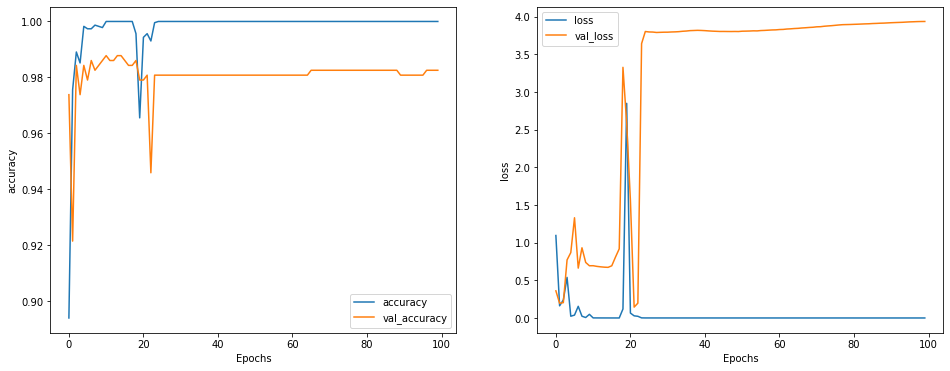

In [ ]:
# Create, compile, and fit the model

input_dim = X_BoW_cv_train_nn.shape[1]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(300, input_dim=input_dim, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

nn_model = model.fit(X_BoW_cv_train_nn, y_BoW_train_nn,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_BoW_cv_test_nn, y_BoW_test_nn))

# Plot graphs of training loss and accuracy
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(nn_model, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(nn_model, 'loss')

In [ ]:
# Make predictions with model

y_nn_predict = model.predict_classes(X_BoW_cv_test_nn)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
# Save the predictions and the model 

nn_pred_list = map(lambda x: x[0], y_nn_predict)
y_nn_predict_series = pd.Series(nn_pred_list)
y_nn_predict_series.to_csv('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/nn_predict.csv', index=False)

model.save('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Models_Step4/')

INFO:tensorflow:Assets written to: /drive/My Drive/Colab Notebooks/CS3315_Project/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_2/assets


In [ ]:
# Multi-Layer Perceptron Neural Network
print('Neural Network Model Performance\n')
print('Accuracy: ', accuracy_score(y_BoW_test_nn, y_nn_predict_series))
print('Precision: ', precision_score(y_BoW_test_nn, y_nn_predict_series))
print('Recall: ', recall_score(y_BoW_test_nn, y_nn_predict_series))
print('F1 Score:',f1_score(y_BoW_test_nn, y_nn_predict_series))

Neural Network Model Performance

Accuracy:  0.9825479930191972
Precision:  0.9844357976653697
Recall:  0.9768339768339769
F1 Score: 0.9806201550387598


Now we will build and evaluate models on the non-BoW, user pattern of life data in the dataset and see how they perform

In [21]:
# Perform train test split on non-BoW data for Random Forest and SVC models

X = all_users[["user_reported_location","user_profile_description","follower_count","following_count", "retweet_ratio", "english_tweet_proportion","earliest_tweet_time","latest_tweet_time", "average_tweet_time", "median_tweet_time", "tweet_count", "stddev_tweet_time", "mode_0", "mode_1", "mode_2", "mode_3",	"mode_4", "mode_5", "mode_6", "mode_7",	"mode_8", "mode_9", "mode_10", "mode_11", "mode_12", "mode_13", "mode_14", "mode_15", "mode_16", "mode_17", "mode_18", "mode_19", "mode_20", "mode_21", "mode_22", "mode_23", "avg_tweets_per_week", "avg_tweets_per_day", "avg_tweets_per_hour", "avg_tweets_per_min", "avg_quote_count", "avg_like_count", "avg_retweet_count", "avg_hashtags", "avg_urls",	"avg_user_mentions"]].copy()

y = all_users["info_op"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
# Run Random Forests Classifier on data using GridSearchCV to detect the optimal parameters

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 150, 200],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
clf = RandomForestClassifier()

# Instantiate the grid search
clf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

clf_grid.fit(X_train, y_train)

print("\n\nThe best parameters for the Random Forest are ", clf_grid.best_params_)

y_RF_predict = clf_grid.predict(X_test)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1378 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3201 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3970 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4821 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 5752 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 6765 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 7858 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 9033 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 10288 tasks      



The best parameters for the Random Forest are  {'bootstrap': True, 'max_depth': 80, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}


In [24]:
# Save Random Forest Predictions to csv and model

y_RF_predict_series = pd.Series(y_RF_predict)
y_RF_predict_series.to_csv('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/RF_predict.csv', index=False)

pickle.dump(clf_grid, open('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/random_forest_model.sav', 'wb'))

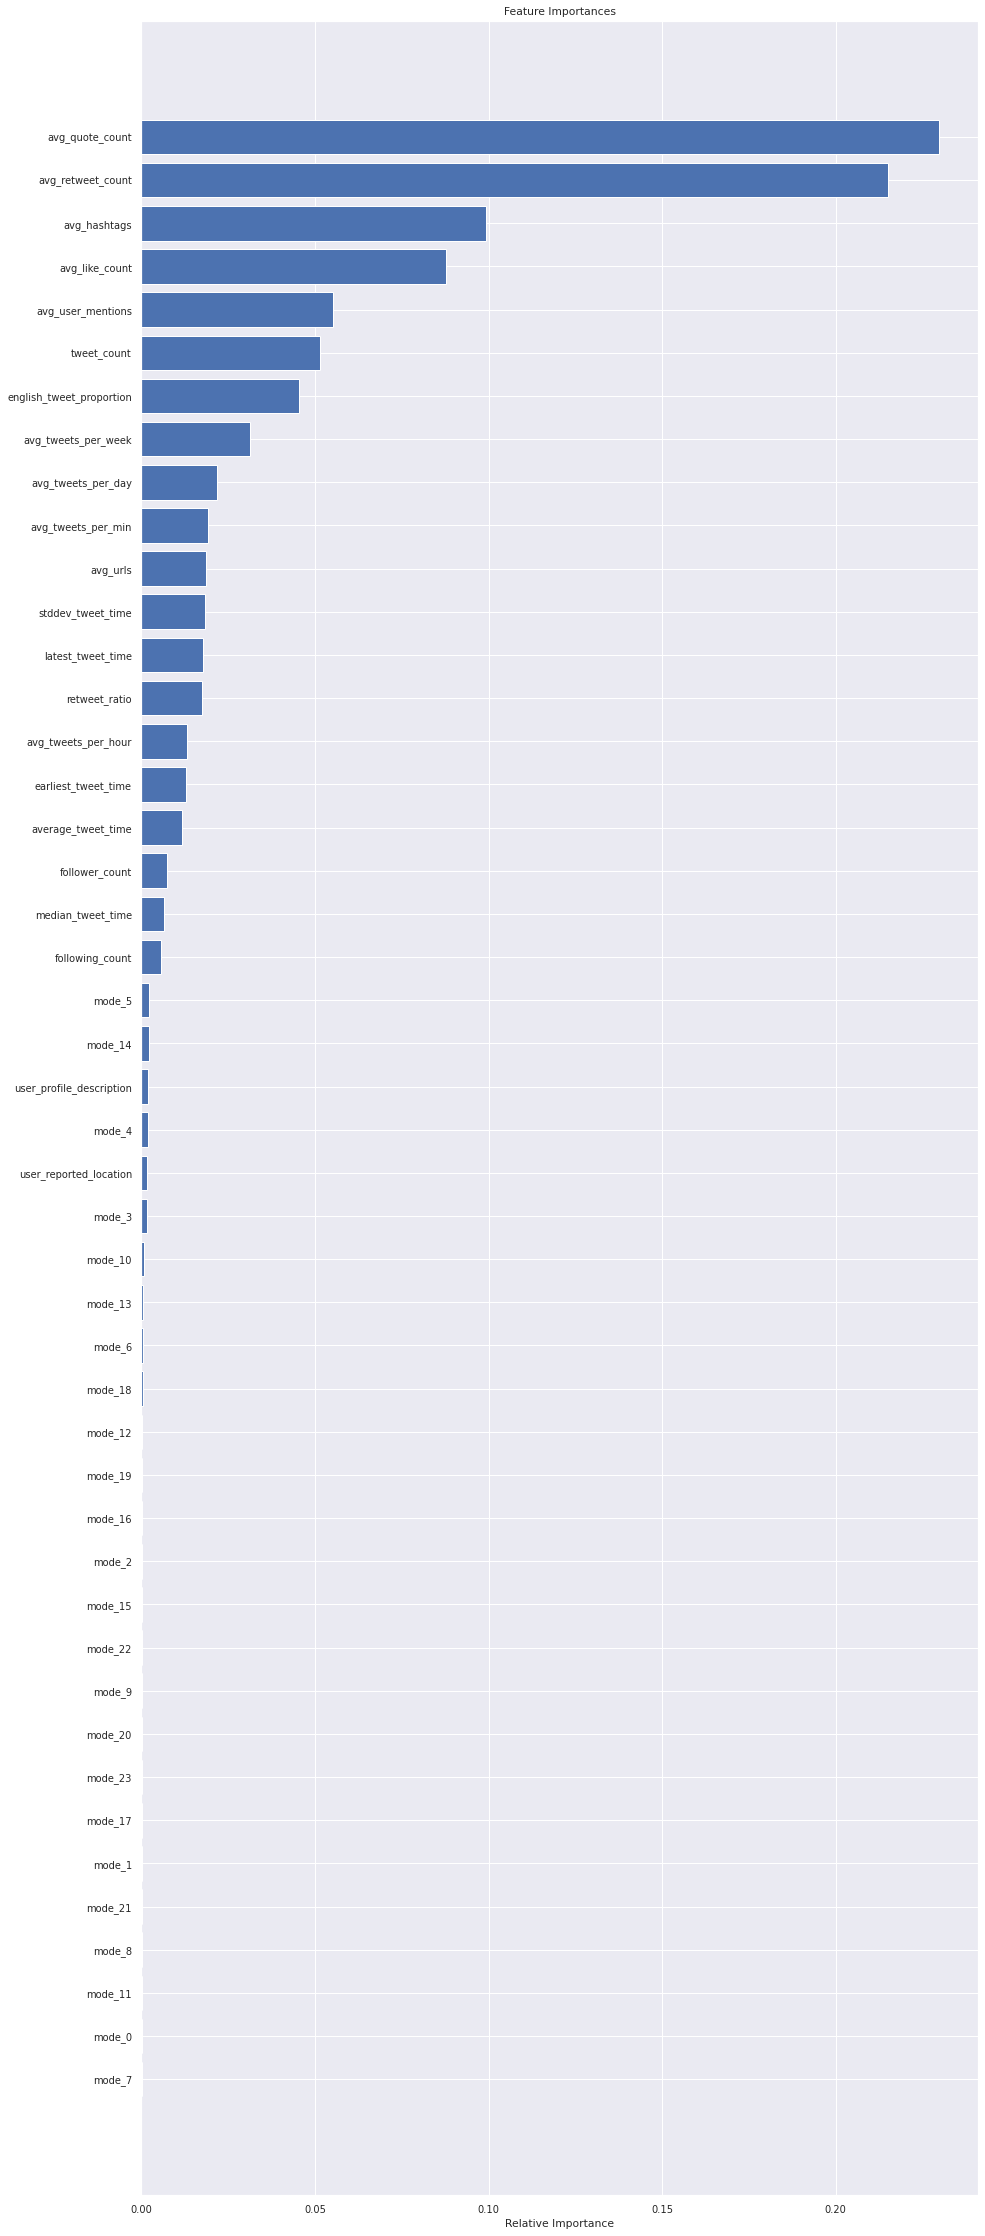

In [23]:
# Display feature importance from Random Forests

features = X.columns
importances = clf_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15,40))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [25]:
# Run SVC as a predictor using GridSearchCV to determine the best parameters

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

parameters = {'SVC__C':[0.001,0.1,10,100,1000,10e5], 'SVC__gamma':[1, 0.1, 0.01, 0.001, 0.0001]}

steps = [('scaler', StandardScaler()), ('SVC', SVC(random_state=42))]

pipeline = Pipeline(steps) # define the pipeline object.

grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, verbose=2)

grid.fit(X_train, y_train)

print("\nThe best parameters for the SVC are ", grid.best_params_)

y_SVC_predict = grid.predict(X_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] SVC__C=0.001, SVC__gamma=1 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... SVC__C=0.001, SVC__gamma=1, total=   3.8s
[CV] SVC__C=0.001, SVC__gamma=1 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ....................... SVC__C=0.001, SVC__gamma=1, total=   3.7s
[CV] SVC__C=0.001, SVC__gamma=1 ......................................
[CV] ....................... SVC__C=0.001, SVC__gamma=1, total=   3.7s
[CV] SVC__C=0.001, SVC__gamma=1 ......................................
[CV] ....................... SVC__C=0.001, SVC__gamma=1, total=   3.7s
[CV] SVC__C=0.001, SVC__gamma=1 ......................................
[CV] ....................... SVC__C=0.001, SVC__gamma=1, total=   3.7s
[CV] SVC__C=0.001, SVC__gamma=0.1 ....................................
[CV] ..................... SVC__C=0.001, SVC__gamma=0.1, total=   3.9s
[CV] SVC__C=0.001, SVC__gamma=0.1 ....................................
[CV] ..................... SVC__C=0.001, SVC__gamma=0.1, total=   3.9s
[CV] SVC__C=0.001, SVC__gamma=0.1 ....................................
[CV] ..................... SVC__C=0.001, SVC__gamma=0.1, total=   3.9s
[CV] SVC__C=0.001, SVC__gamma=0.1 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.7min finished



The best parameters for the SVC are  {'SVC__C': 1000, 'SVC__gamma': 0.001}


In [26]:
# Save SVC predictions to csv and model

y_SVC_predict_series = pd.Series(y_SVC_predict)
y_SVC_predict_series.to_csv('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Predictions_Step4/y_SVC_predict.csv', index=False)

pickle.dump(clf_grid, open('/mypath/Step 4 - Exploratory Data Analysis and Classification Model Development/Models_Step4/SVC_model.sav', 'wb'))

Evaluate Accuracy, Precision, Recall for Random Forest and SVC models trained on the user pattern-of-life features


In [27]:
# Random Forest Metrics
print('Random Forest prediction on non-BoW features\n')
print('Accuracy: ', accuracy_score(y_test, y_RF_predict))
print('Precision: ', precision_score(y_test, y_RF_predict))
print('Recall: ', recall_score(y_test, y_RF_predict))
print('F1 Score:',f1_score(y_test.tolist(), y_RF_predict))

# SVC Metrics
print('\n\nSVC prediction on non-BoW features\n')
print('Accuracy: ', accuracy_score(y_test, y_SVC_predict))
print('Precision: ', precision_score(y_test, y_SVC_predict))
print('Recall: ', recall_score(y_test, y_SVC_predict))
print('F1 Score:',f1_score(y_test.tolist(), y_SVC_predict))

Random Forest prediction on non-BoW features

Accuracy:  0.9947643979057592
Precision:  0.9904648390941597
Recall:  0.9987980769230769
F1 Score: 0.9946140035906643


SVC prediction on non-BoW features

Accuracy:  0.9848749272833043
Precision:  0.9786223277909739
Recall:  0.9903846153846154
F1 Score: 0.984468339307049


Evaluate ensemble voting metrics combining the different models. We will take the 4 highest-performing models and test every combination of 3. We will use 2 models using the BoW as input features and 2 using the other input features. We will use the best performing models Stochastic Gradient Descent Classifier with TFIDF and Stochastic Gradient Descent with Count Vectorizer, as well as the Random Forest and Support Vector Classifier models.

In [ ]:
# Get prediction results to use with ensemble voting methods

sgd_cv_file = drive.CreateFile({'id': 'insert file id'})
sgd_cv_file.GetContentFile('y_sgd_cv_predict_series.csv')

y_sgd_cv_predict = pd.read_csv('y_sgd_cv_predict_series.csv')
y_sgd_cv_predict = pd.Series(y_sgd_cv_predict['0'])

sgd_tfidf_file = drive.CreateFile({'id': 'insert file id'})
sgd_tfidf_file.GetContentFile('y_sgd_tfidf_predict_series.csv')

y_sgd_tfidf_predict = pd.read_csv('y_sgd_tfidf_predict_series.csv')
y_sgd_tfidf_predict = pd.Series(y_sgd_tfidf_predict['0'])

rf_file = drive.CreateFile({'id': 'insert file id'})
rf_file.GetContentFile('RF_predict.csv')

y_RF_predict = pd.read_csv('RF_predict.csv')
y_RF_predict = pd.Series(y_RF_predict['0'])

SVC_file = drive.CreateFile({'id': 'insert file id'})
SVC_file.GetContentFile('y_SVC_predict.csv')

y_SVC_predict = pd.read_csv('y_SVC_predict.csv')
y_SVC_predict = pd.Series(y_SVC_predict['0'])

In [29]:
# SGD CV, SGD TFIDF, Random Forests Ensemble

y_pred_sgdcv_sgdtfidf_rf = tweetProcessing.predictionVoting(y_sgd_cv_predict, y_sgd_tfidf_predict, y_RF_predict)

In [30]:
# SGD CV, SGD TFIDF, SVC Ensemble

y_pred_sgdcv_sgdtfidf_svc = tweetProcessing.predictionVoting(y_sgd_cv_predict, y_sgd_tfidf_predict, y_SVC_predict)

In [31]:
# SGD CV, SVC, Random Forests Ensemble

y_pred_sgdcv_rf_svc = tweetProcessing.predictionVoting(y_sgd_cv_predict, y_RF_predict, y_SVC_predict)

In [32]:
# SGD TFIDF, SVC, Random Forests Ensemble

y_pred_sgdtfidf_svc_rf = tweetProcessing.predictionVoting(y_sgd_tfidf_predict, y_RF_predict, y_SVC_predict)

In [33]:
# Ensemble Metrics
print('\nSGD CV, SGD TFIDF, Random Forests Ensemble\n')
print('Accuracy: ', accuracy_score(y_test, y_pred_sgdcv_sgdtfidf_rf))
print('Precision: ', precision_score(y_test, y_pred_sgdcv_sgdtfidf_rf))
print('Recall: ', recall_score(y_test, y_pred_sgdcv_sgdtfidf_rf))
print('F1 Score:',f1_score(y_test, y_pred_sgdcv_sgdtfidf_rf))

# Ensemble Metrics
print('\nSGD CV, SGD TFIDF, SVC Ensemble\n')
print('Accuracy: ', accuracy_score(y_test, y_pred_sgdcv_sgdtfidf_svc))
print('Precision: ', precision_score(y_test, y_pred_sgdcv_sgdtfidf_svc))
print('Recall: ', recall_score(y_test, y_pred_sgdcv_sgdtfidf_svc))
print('F1 Score:',f1_score(y_test, y_pred_sgdcv_sgdtfidf_svc))

# Ensemble Metrics
print('\nSGD CV, SVC, Random Forests Ensemble\n')
print('Accuracy: ', accuracy_score(y_test, y_pred_sgdcv_rf_svc))
print('Precision: ', precision_score(y_test, y_pred_sgdcv_rf_svc))
print('Recall: ', recall_score(y_test, y_pred_sgdcv_rf_svc))
print('F1 Score:',f1_score(y_test, y_pred_sgdcv_rf_svc))

# Ensemble Metrics
print('\nSGD TFIDF, SVC, Random Forests Ensemble\n')
print('Accuracy: ', accuracy_score(y_test, y_pred_sgdtfidf_svc_rf))
print('Precision: ', precision_score(y_test, y_pred_sgdtfidf_svc_rf))
print('Recall: ', recall_score(y_test, y_pred_sgdtfidf_svc_rf))
print('F1 Score:',f1_score(y_test, y_pred_sgdtfidf_svc_rf))


SGD CV, SGD TFIDF, Random Forests Ensemble

Accuracy:  0.9895287958115183
Precision:  0.9845238095238096
Recall:  0.9939903846153846
F1 Score: 0.9892344497607656

SGD CV, SGD TFIDF, SVC Ensemble

Accuracy:  0.9872018615474113
Precision:  0.9821428571428571
Recall:  0.9915865384615384
F1 Score: 0.9868421052631579

SGD CV, SVC, Random Forests Ensemble

Accuracy:  0.9947643979057592
Precision:  0.991636798088411
Recall:  0.9975961538461539
F1 Score: 0.9946075494307969

SGD TFIDF, SVC, Random Forests Ensemble

Accuracy:  0.9936009307737056
Precision:  0.9892729439809297
Recall:  0.9975961538461539
F1 Score: 0.9934171154997008
